*Antonio Coín Castro*     


# Bayesian Functional Linear Regression

In [1]:
# -- Libraries

import os
import pickle

import arviz as az
import numpy as np
import pandas as pd
import skfda

import utils
import plot_utils
import preprocessing
import simulation
import bayesian_model
import mle

from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.smoothing.kernel_smoothers import \
    NadarayaWatsonSmoother as NW
from skfda.representation.basis import BSpline, Fourier
from skfda.representation.grid import FDataGrid
from sklearn.model_selection import KFold, train_test_split

from _fpls import FPLSBasis

In [2]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)

# Multiprocessing
N_CORES = 4

# Ignore warnings
np.seterr(over='ignore', divide='ignore')
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

We consider the model

$$
Y = \alpha_0 + \Psi^{-1}_{X}(\alpha) + \varepsilon,
$$

i.e.,

$$
Y_i\mid X_i=x_i \sim \mathcal N\left(\alpha_0 + \sum_{j=1}^p \beta_jx_i(\tau_j), \ \sigma^2\right).
$$

The prior distributions we choose are:

\begin{align*}
  \pi(\alpha_0, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N\left(b_0, g\sigma^2\left[\mathcal X_\tau' \mathcal X_\tau + \eta \lambda_{\text{max}}(\mathcal X_\tau' \mathcal X_\tau)I\right]^{-1}\right),
\end{align*}

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\alpha_0, \log\sigma) \propto 1.
$$

Writing the parameter vector as $\theta = (\beta, \tau, \alpha_0, \log\sigma)$, the joint posterior probability is:

$$
\pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \frac{|G_\tau|^{1/2}}{\sigma^{p+n}} \exp\left\{ -\frac{1}{2\sigma^2} \left(\|Y- \alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right) \right\}.
$$

Hence, the log-posterior probability is:

$$
\log \pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \frac{1}{2}\log |G_\tau| - (p+n)\log \sigma -\frac{1}{2\sigma^2} \left(\|Y-\alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right).  
$$



The metrics considered for model evaluation will be:

- RMSE.
- $R^2$.

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim GP(0, K(s, t))$, a response variable given by either a $L^2$ model or a "simple" RKHS function, a value of $\alpha_0=5$ and a variance of $\sigma^2=0.5$. More precisely, we choose one of

$$
Y_i \sim \mathcal N\big(5 -5X_i(0.1) + 10X_i(0.8), \ 0.5\big)
$$

or

$$
Y_i \sim \mathcal N\left(5 + \int_0^1 \beta(t)X_i(t)\, dt, \ 0.5\right),
$$

where $\beta \in L^2[0, 1]$.

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation.

In [3]:
# -- Data generation parameters

SYNTHETIC_DATA = True
MODEL_GEN = "RKHS"  # 'L2' or 'RKHS'
REAL_DATA = "Aemet"

INITIAL_SMOOTHING = 'NW'  # 'NW'  # None, 'NW' or 'Basis'
N_BASIS = 16
SCALE_PREDICTORS = False
STANDARDIZE_RESPONSE = False

kernel_fn = simulation.fractional_brownian_kernel
beta_coef = simulation.cholaquidis_scenario3

basis = BSpline(n_basis=N_BASIS)
smoothing_params = np.logspace(-4, 4, 50)

n_train, n_test = 100, 50
N = 100
tau_range = (0, 1)

In [4]:
# -- Dataset generation

if SYNTHETIC_DATA:
    grid = np.linspace(tau_range[0] + 1./N, tau_range[1], N)

    beta_true = [-5., 10.]
    tau_true = [0.1, 0.8]
    alpha0_true = 5.
    sigma2_true = 0.5

    if MODEL_GEN == "L2":
        x, y = simulation.generate_gp_l2_dataset(
            grid,
            kernel_fn,
            n_train + n_test,
            beta_coef,
            alpha0_true,
            sigma2_true,
            rng=rng
        )
    elif MODEL_GEN == "RKHS":
        x, y = simulation.generate_gp_rkhs_dataset(
            grid,
            kernel_fn,
            n_train + n_test,
            beta_true,
            tau_true,
            alpha0_true,
            sigma2_true,
            rng=rng
        )
    else:
        raise ValueError("Invalid model generation strategy.")

    # Train/test split
    X, X_test, Y, Y_test = train_test_split(
        x, y, train_size=n_train, random_state=SEED)

    # Create FData object
    X_fd = skfda.FDataGrid(X, grid)
    X_test_fd = skfda.FDataGrid(X_test, grid)

else:  # Real data
    if REAL_DATA == "Tecator":
        x, y = skfda.datasets.fetch_tecator(return_X_y=True)
        y = np.sqrt(y[:, 1])  # Sqrt-Fat
    elif REAL_DATA == "Aemet":
        data = skfda.datasets.fetch_aemet()['data']
        data_matrix = data.data_matrix
        temperature = data_matrix[:, :, 0]
        x = FDataGrid(temperature, data.grid_points)
        # Log-Sum of log-precipitation for each station
        y = np.log(np.exp(data_matrix[:, :, 1]).sum(axis=1))
    else:
        raise ValueError("REAL_DATA must be 'Tecator' or 'Aemet'.")

    X_fd, X_test_fd, Y, Y_test = train_test_split(
        x, y, train_size=0.8, random_state=SEED)

    N = len(X_fd.grid_points[0])
    grid = utils.normalize_grid(x.grid_points[0], tau_range[0], tau_range[1])
    n_train, n_test = len(X_fd.data_matrix), len(X_test_fd.data_matrix)

# Smooth data

if INITIAL_SMOOTHING is not None:
    if INITIAL_SMOOTHING == "NW":
        smoother = NW()
    elif INITIAL_SMOOTHING == "Basis":
        smoother = BasisSmoother(basis)
    else:
        raise ValueError(
            f"Expected 'NW' or 'Basis' but got {INITIAL_SMOOTHING}.")

    X_fd, best_smoother, X_test_fd = preprocessing.smooth_data(
        X_fd,
        smoother,
        smoothing_params,
        X_test_fd
    )

    print(
        "Smoother: {}".format(
            best_smoother.best_estimator_.__class__.__name__))
    print(
        "Smoothing parameter: {:.3f}".format(
            best_smoother.best_params_['smoothing_parameter']))

# Standardize data
X_fd, X_test_fd = preprocessing.standardize_predictors(
    X_fd, X_test_fd, SCALE_PREDICTORS)

if STANDARDIZE_RESPONSE:
    Y, Y_test = preprocessing.standardize_response(Y, Y_test)

# Get data matrices

X = X_fd.data_matrix.reshape(-1, N)
X_test = X_test_fd.data_matrix.reshape(-1, N)

Smoother: NadarayaWatsonSmoother
Smoothing parameter: 0.013


 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning:One or more of the test scores are non-finite: [   nan    nan    nan    nan    nan    nan    nan -0.001 -0.001 -0.001
 -0.001 -0.001 -0.    -0.    -0.001 -0.001 -0.001 -0.002 -0.003 -0.006
 -0.012 -0.023 -0.042 -0.063 -0.077 -0.086 -0.09  -0.092 -0.093 -0.094
 -0.094 -0.094 -0.094 -0.094 -0.094 -0.094 -0.094 -0.094 -0.094 -0.094
 -0.094 -0.094 -0.094 -0.094 -0.094 -0.094 -0.094 -0.094 -0.094 -0.094]


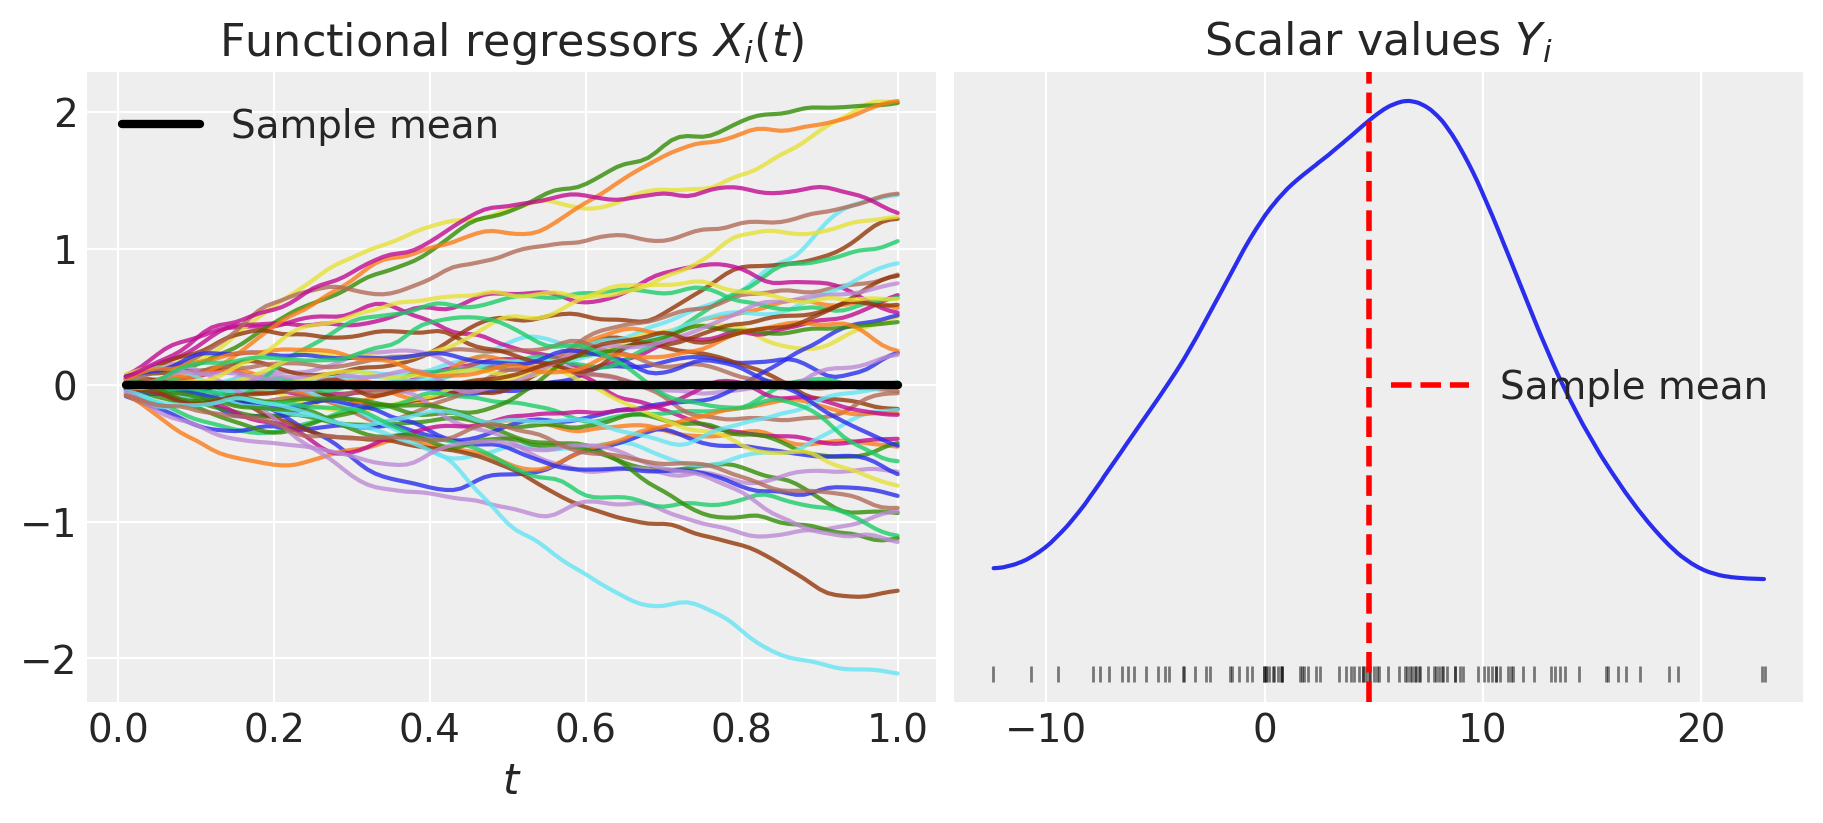

In [5]:
# -- Dataset visualization

plot_utils.plot_dataset_regression(
    X,
    Y,
    n_samples=n_train if not SYNTHETIC_DATA else n_train//2
)

## Common model hyperparameters

In our algorithms, we consider an unconstrained tranformed parameter space $\tilde \Theta=\mathbb{R}^{2\hat p+2}$ via the bijections

- $\tau_j \mapsto \operatorname{logit}(\tau_j)$.
- $\sigma^2 \mapsto \log\sigma$.

In [6]:
# -- Model hyperparameters

p_max = 3
g = 5
eta = 0.1

mle_method = 'L-BFGS-B'  # 'Nelder-Mead', 'Powell' or 'L-BFGS-B'
mle_strategy = 'global'

prior_p = {
    1: 0.10,
    2: 0.60,
    3: 0.30,
}

beta_range = (-500, 500)

INCLUDE_P = False
TRANSFORM_TAU = False
TRANSFORM_SIGMA = True
FIT_SK = True
COMPUTE_MLE = True

In [7]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
if INCLUDE_P:
    theta_names = ["p"] + theta_names

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]
if INCLUDE_P:
    theta_labels_grouped = [r"$p$"] + theta_labels_grouped

# Individual labels
theta_labels = [] if not INCLUDE_P else [theta_labels_grouped[0]]
for i in range(p_max):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_max):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={"vector": dict(
        zip(np.arange(p_max), np.arange(1, p_max + 1)))}
)

In [8]:
# -- Parameter space and miscellaneous

if TRANSFORM_TAU:
    tau_ttr = bayesian_model.Logit()
else:
    tau_ttr = bayesian_model.Identity()

if TRANSFORM_SIGMA:
    sigma2_ttr = bayesian_model.LogSq()
else:
    sigma2_ttr = bayesian_model.Identity()

# Parameter space
theta_space = bayesian_model.ThetaSpace(
    p_max,
    grid,
    include_p=INCLUDE_P,
    names=theta_names,
    labels=theta_labels,
    labeller=theta_labeller,
    tau_range=tau_range,
    beta_range=beta_range,
    tau_ttr=tau_ttr,
    sigma2_ttr=sigma2_ttr
)

# Statistics for posterior predictive checks
point_estimators_bpv = [
    ("min", np.min),
    ("max", np.max),
    ("median", np.median),
    ("mean", np.mean),
    ("std", np.std)
]

# Folds for CV
folds = KFold(shuffle=True, random_state=SEED)

## Sklearn model comparison

In [9]:
# -- Select family of regressors

alphas = np.logspace(-4, 4, 20)
n_selected = [5, 10, 15, 20, 25, X.shape[1]]
n_components = [2, 3, 4, 5, 10]
n_basis_bsplines = [8, 10, 12, 14, 16]
n_basis_fourier = [3, 5, 7, 9, 11]
n_neighbors = [3, 5, 7]

basis_bspline = [BSpline(n_basis=p) for p in n_basis_bsplines]
basis_fourier = [Fourier(n_basis=p) for p in n_basis_fourier]

basis_fpls = []
for p in n_components:
    try:
        basis_fpls.append(FPLSBasis(X_fd, Y, n_basis=p))
    except ValueError:
        print(f"Can't create FPLSBasis with n_basis={p}")
        continue

params_regularizer = {"reg__alpha": alphas}
params_svm = {"reg__C": alphas,
              "reg__gamma": ['auto', 'scale']}
params_select = {"selector__p": n_selected}
params_pls = {"reg__n_components": n_components}
params_dim_red = {"dim_red__n_components": n_components}
params_basis = {"basis__basis": basis_bspline + basis_fourier}
params_basis_fpca = {"basis__n_basis": n_components}
params_basis_fpls = {"basis__basis": basis_fpls}
params_knn = {"reg__n_neighbors": n_neighbors,
              "reg__weights": ['uniform', 'distance']}
params_mrmr = {"var_sel__method": ["MID", "MIQ"],
               "var_sel__n_features_to_select": n_components}

regressors = utils.linear_regression_comparison_suite(
    params_regularizer,
    params_select,
    params_dim_red,
    params_svm,
    params_basis,
    params_pls,
    params_knn,
    random_state=SEED
)

In [10]:
# -- Fit models and show metrics

if FIT_SK:
    df_metrics_sk, reg_cv = utils.cv_sk(
        regressors,
        X_fd,
        Y,
        X_test_fd,
        Y_test,
        folds,
        n_jobs=N_CORES,
        verbose=True
    )
    display(df_metrics_sk.style.hide_index())

  Fitting sk_lasso...


 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.256e+00, tolerance: 5.415e-01


  Fitting sk_pls1...
  Fitting manual_sel+sk_ridge...
  Fitting fpca+sk_ridge...
  Fitting pca+sk_ridge...
  Fitting pls+sk_ridge...
  Fitting rmh+sk_ridge...
  Fitting manual_sel+sk_svm_rbf...
  Fitting fpca+sk_svm_rbf...
  Fitting pca+sk_svm_rbf...
  Fitting pls+sk_svm_rbf...
  Fitting rmh+sk_svm_rbf...
  Fitting sk_apls...
  Fitting sk_flin_basis...
  Fitting sk_fpls1_basis...


 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:
35 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/

  Fitting sk_fknn...


## Maximum Likelihood Estimator

In [11]:
# -- MLE computation

if COMPUTE_MLE:
    print(f"-- Computing MLE with {N_CORES} independent runs --")

    theta_space_fixed = theta_space.copy_p_fixed()

    mle_theta, bic = mle.compute_mle(
        X,
        Y,
        theta_space_fixed,
        kind='linear',
        method=mle_method,
        strategy=mle_strategy,
        n_jobs=N_CORES,
        rng=rng
    )

    Y_pred_mle = bayesian_model.generate_response_linear(
        X_test, mle_theta, theta_space_fixed, noise=False
    )

    df_metrics_mle = utils.linear_regression_metrics(
        Y_test,
        Y_pred_mle,
        theta_space.p_max,
        "mle"
    )
    print(f"\nBIC [p={p_max}]: {bic:.3f}")
    display(pd.DataFrame(zip(theta_space_fixed.labels, mle_theta),
                         columns=["", "MLE"]).style.hide_index())
    print("Regression metrics:")
    display(df_metrics_mle.style.hide_index())

-- Computing MLE with 4 independent runs --


 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:invalid value encountered in subtract



BIC [p=3]: 60.687


Regression metrics:


## The Ensemble Sampler and the *emcee* library

In [12]:
from mcmc_sampler import BayesianLinearRegressionEmcee
import emcee

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [24]:
# -- Sampler parameters

n_walkers = 64
n_iter_warmup = 100
n_iter = 1000

compute_pp = True
compute_ll = False
frac_random = 0.3

moves = [
    (emcee.moves.StretchMove(), 0.7),
    (emcee.moves.WalkMove(), 0.3)
]

thin = 1
thin_pp = 5

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [25]:
# -- Run sampler

print("-- Running affine-invariant ensemble sampler "
      f"with {N_CORES} cores --")

reg_emcee = BayesianLinearRegressionEmcee(
    theta_space,
    n_walkers,
    n_iter,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    n_iter_warmup=n_iter_warmup,
    initial_state='mle',
    frac_random=frac_random,
    moves=moves,
    compute_pp=compute_pp,
    compute_ll=compute_ll,
    thin=thin,
    thin_pp=thin_pp,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    progress_notebook=True,
    random_state=SEED,  # change to 'rng' for different outputs each time
)

if FAST_RUN:
    df_metrics_emcee = utils.run_bayesian_model(
        reg_emcee,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="emcee",
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        verbose=True,
        notebook=True,
        random_state=SEED,
    )
    if COMPUTE_MLE:
        df_metrics_emcee = df_metrics_emcee.append(df_metrics_mle)
    if FIT_SK:
        df_metrics_emcee = df_metrics_emcee.append(df_metrics_sk)

    df_metrics_emcee.sort_values(
        df_metrics_emcee.columns[-2],
        inplace=True
    )
    display(df_metrics_emcee.style.hide_index())
else:
    reg_emcee.fit(X, Y)
    print(f"Mean acceptance: {100*reg_emcee.mean_acceptance():.3f}%")

idata_emcee = reg_emcee.get_idata()

-- Running affine-invariant ensemble sampler with 4 cores --
[BFLinReg] Computing MLE...
[BFLinReg] MCMC warmup iterations...


[BFLinReg] MCMC:   0%|          | 0/1000 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [72.185 71.024 75.004 68.343 63.622 78.813 68.99  82.129]


[BFLinReg] Discarding the first 100 samples...
Mean acceptance: 24.856%


mean     sd  hdi_3%  hdi_97%     min     max  median    mode
β[0]        -1.172  1.075  -1.939   -0.521  -6.127  11.576  -1.213  -1.096
β[1]        -3.619  2.650  -5.117   -3.233  -7.029  13.015  -4.122  -4.191
β[2]        10.451  2.548  10.330   11.652 -16.063  12.186  10.937  10.889
τ[0]         0.592  0.087   0.448    0.708   0.009   0.986   0.604   0.638
τ[1]         0.113  0.125   0.065    0.115   0.001   0.796   0.089   0.089
τ[2]         0.780  0.074   0.785    0.805   0.070   0.812   0.796   0.803
$\alpha_0$   4.815  0.161   4.650    4.957   4.257   6.585   4.799   4.791
$\sigma^2$   1.024  2.795   0.289    0.629   0.252  40.795   0.433   0.450


Computing metrics...

Generating posterior predictive samples...


### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value. The effective sample size is computed as suggested [here (p.66)](https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/mcmc_slides.pdf). Missing values are replaced with a value of $0$.

In [26]:
# -- Sampler statistics and trace (with burn-in and thinning)

# Get number of samples
n_samples_emcee = reg_emcee.total_samples()

# Get autocorrelation times
autocorr = reg_emcee.autocorrelation_times()

pd.DataFrame(
    zip(theta_labels, autocorr, n_samples_emcee/autocorr),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide_index()

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 18;
tau: [64.575 66.612 65.956 64.123 61.914 72.158 64.59  59.824]


In [27]:
# -- Trace summary

reg_emcee.summary()

mean     sd  hdi_3%  hdi_97%     min     max  median    mode
β[0]        -1.172  1.075  -1.939   -0.521  -6.127  11.576  -1.213  -1.096
β[1]        -3.619  2.650  -5.117   -3.233  -7.029  13.015  -4.122  -4.191
β[2]        10.451  2.548  10.330   11.652 -16.063  12.186  10.937  10.889
τ[0]         0.592  0.087   0.448    0.708   0.009   0.986   0.604   0.638
τ[1]         0.113  0.125   0.065    0.115   0.001   0.796   0.089   0.089
τ[2]         0.780  0.074   0.785    0.805   0.070   0.812   0.796   0.803
$\alpha_0$   4.815  0.161   4.650    4.957   4.257   6.585   4.799   4.791
$\sigma^2$   1.024  2.795   0.289    0.629   0.252  40.795   0.433   0.450

Combined density and trace plot:


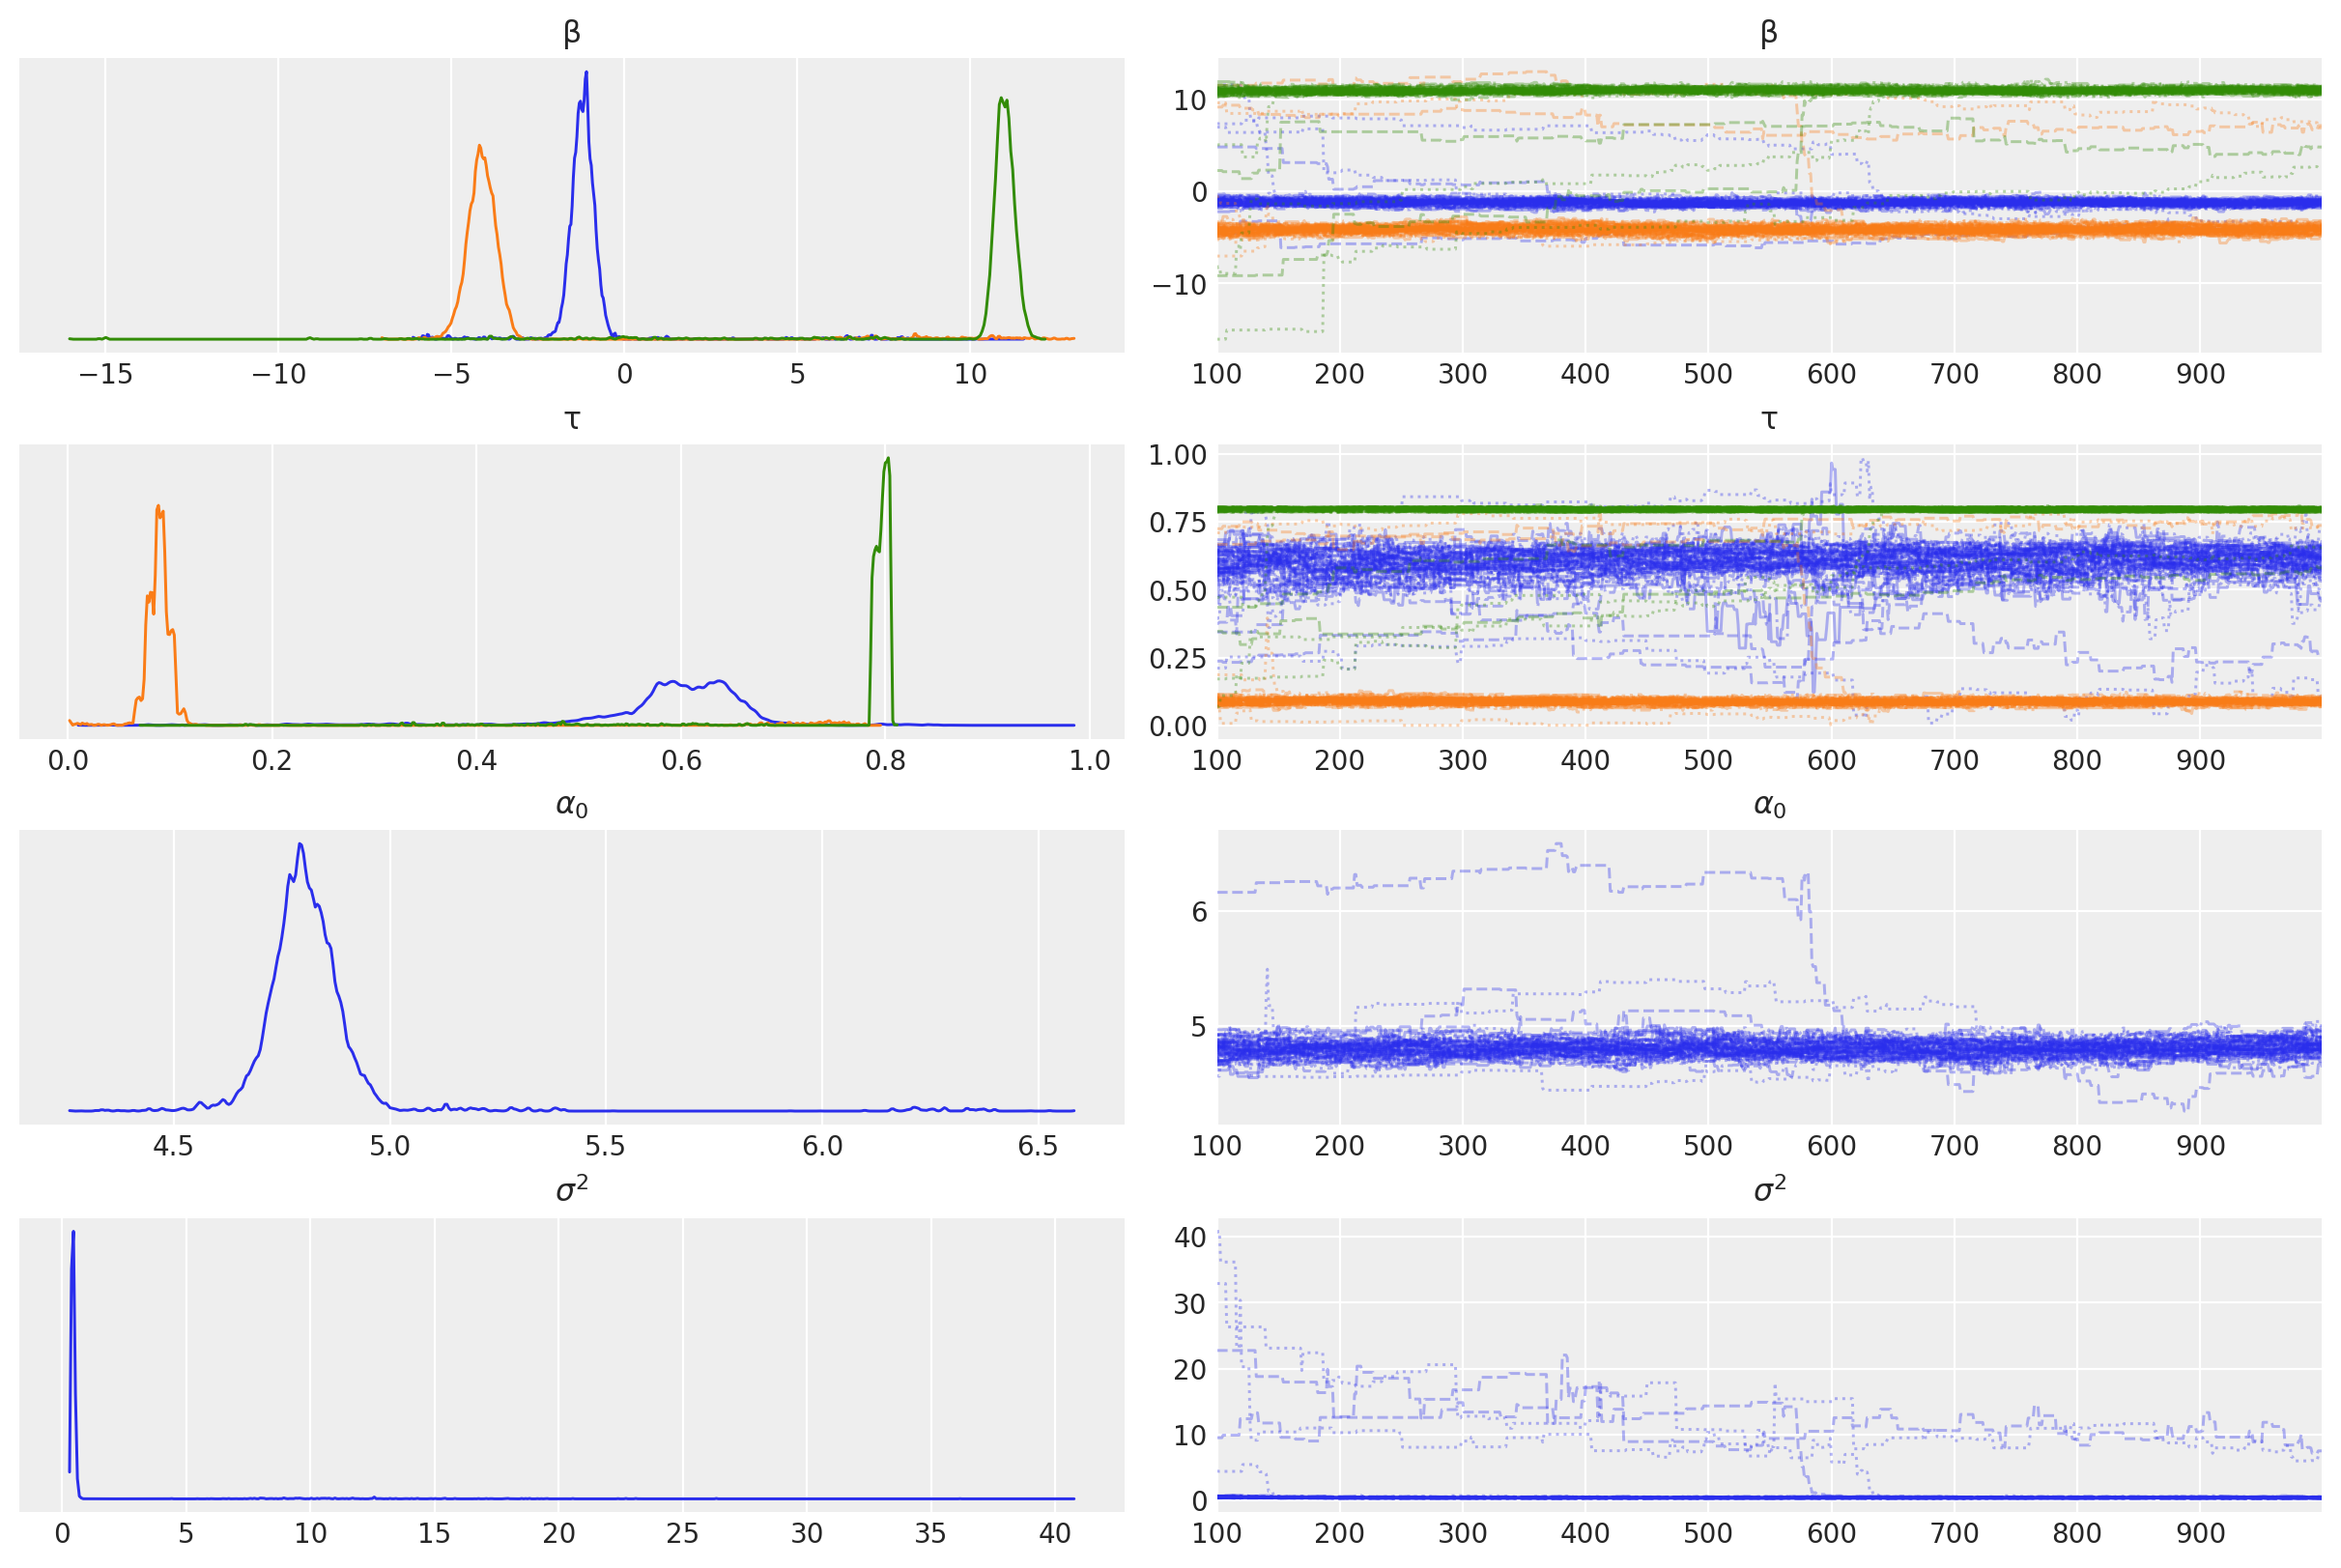

In [28]:
# -- Trace plot

az.plot_trace(
    idata_emcee,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)

print("Combined density and trace plot:")

Marginal posterior distributions:


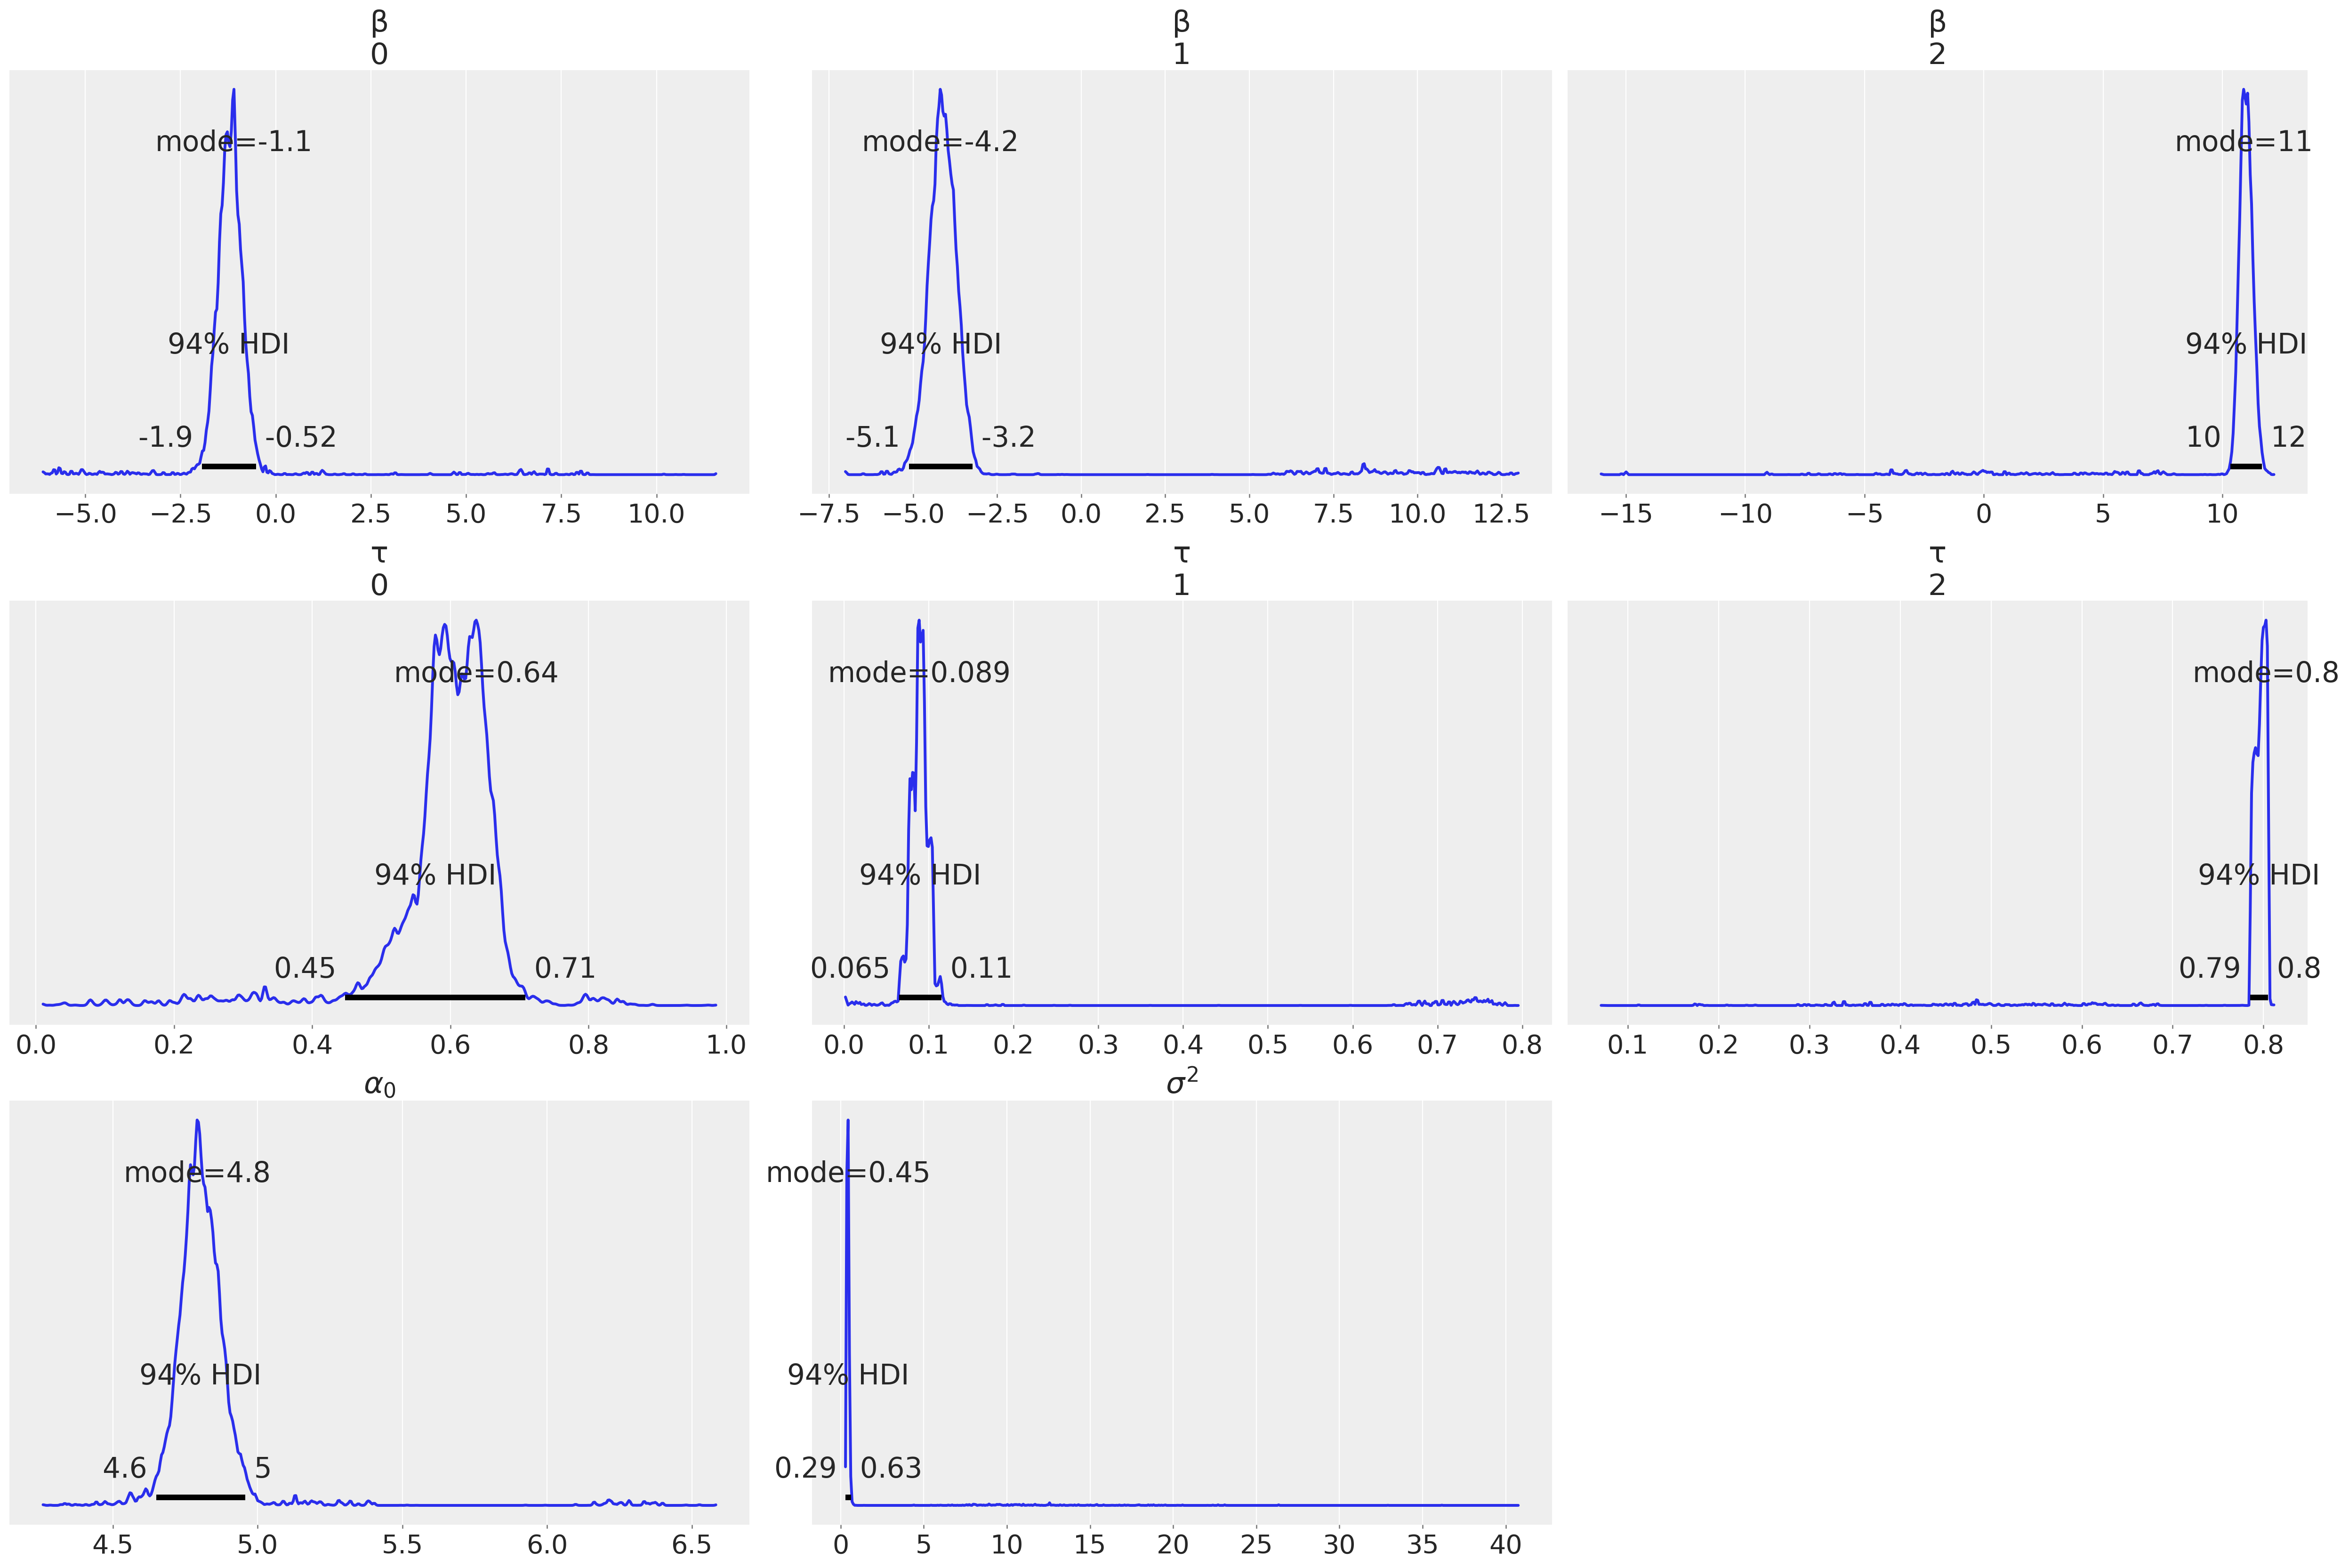

In [29]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

We can perform a couple of visual posterior predictive checks. In particular:
    
- A plot of the distribution of $Y$ and the distribution of $\{Y^*_m\}_m$ (one for every sample $\theta_m$ of the chain), generated using the original traning data $X$.
- A plot of the distribution of $T(Y^*)$, where $T(x)=\bar x$. 

We also show the Bayesian p-value for several statistics, which is defined as $P(T(y^*)\leq T(y)\mid y)$, and is computed by simply measuring the proportion of generated samples $\{T(Y^*_m)\}_m$ that fall below the real value of the statistic. It is expected to be around $0.5$ when the model accurately represents the data.

bpv [T=min]: 0.488
bpv [T=max]: 0.511
bpv [T=median]: 0.644
bpv [T=mean]: 0.672
bpv [T=std]: 0.820


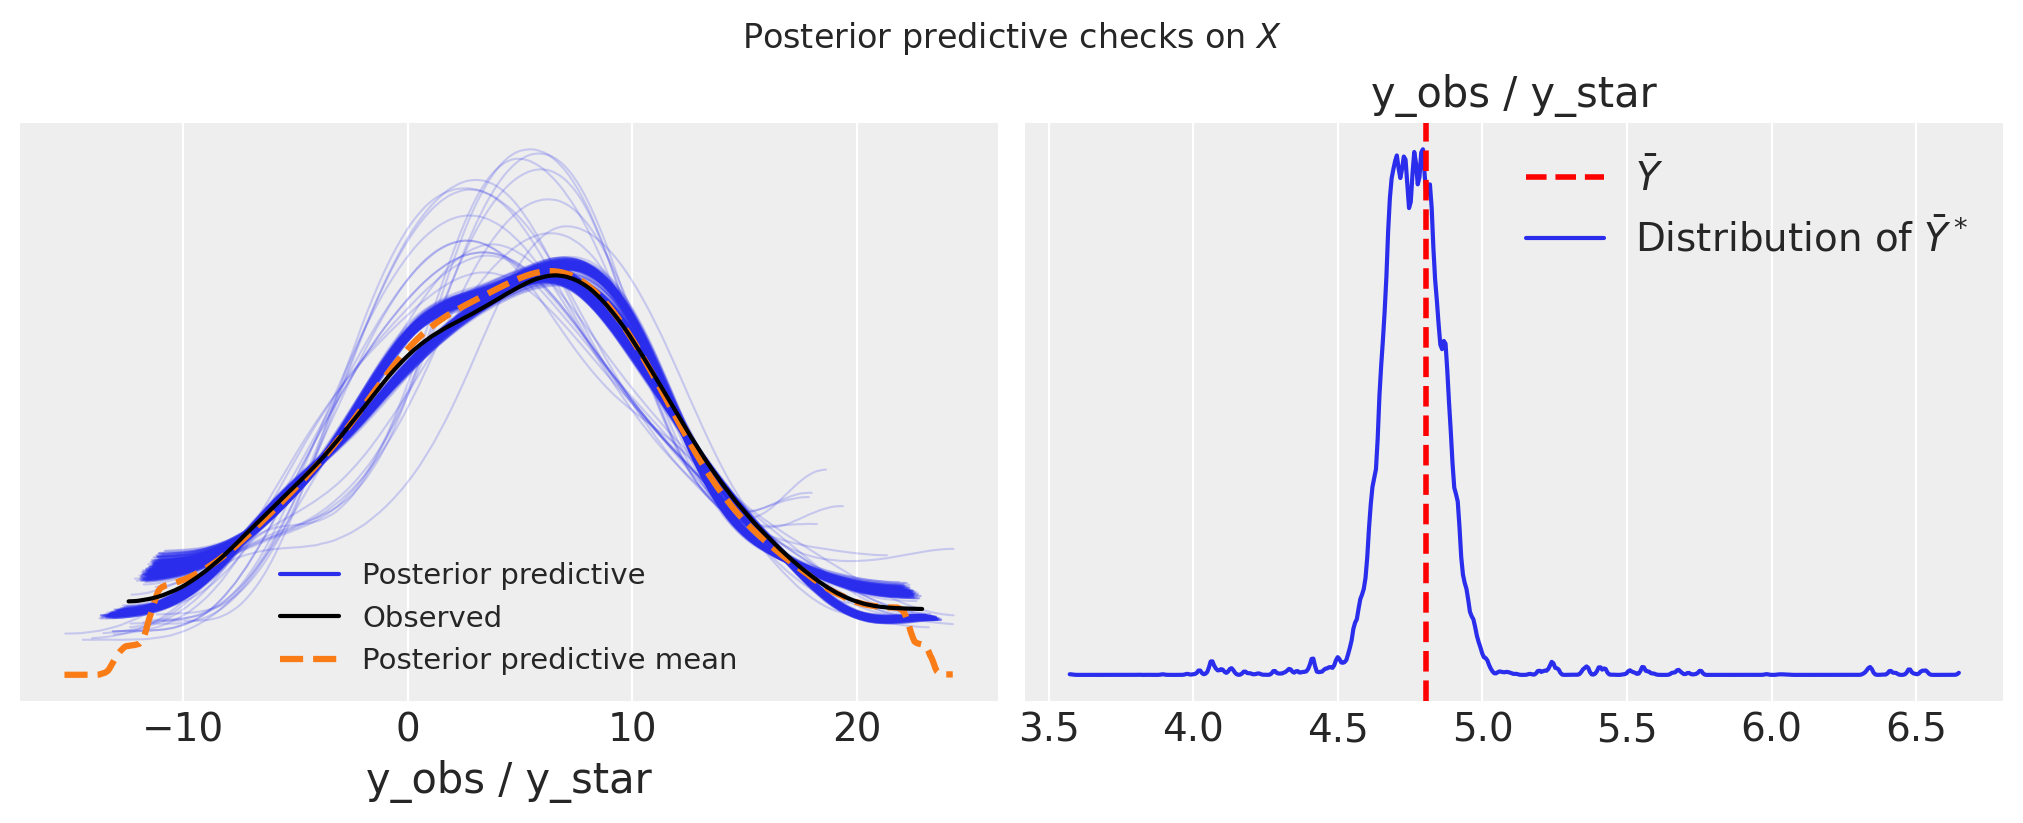

In [30]:
# -- Generate and plot posterior predictive checks from X

if "posterior_predictive" not in idata_emcee:
    pp = bayesian_model.generate_pp(
        idata_emcee, X, theta_space, rng=rng, verbose=True)
    utils.pp_to_idata([pp], idata_emcee, ['y_star'], merge=True)
else:
    pp = idata_emcee.posterior_predictive['y_star'].to_numpy()

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X$")

plot_utils.plot_ppc(
    idata_emcee,
    n_samples=500,
    ax=axs[0],
    data_pairs={'y_obs': 'y_star'}
)

az.plot_bpv(idata_emcee,
            kind='t_stat',
            t_stat='mean',
            ax=axs[1],
            plot_mean=False,
            data_pairs={'y_obs': 'y_star'},
            bpv=False
            )
axs[1].axvline(Y.mean(),
               ls="--",
               color="r",
               lw=2,
               label=r"$\bar Y$"
               )
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*$")])
axs[1].legend(handles=handles)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


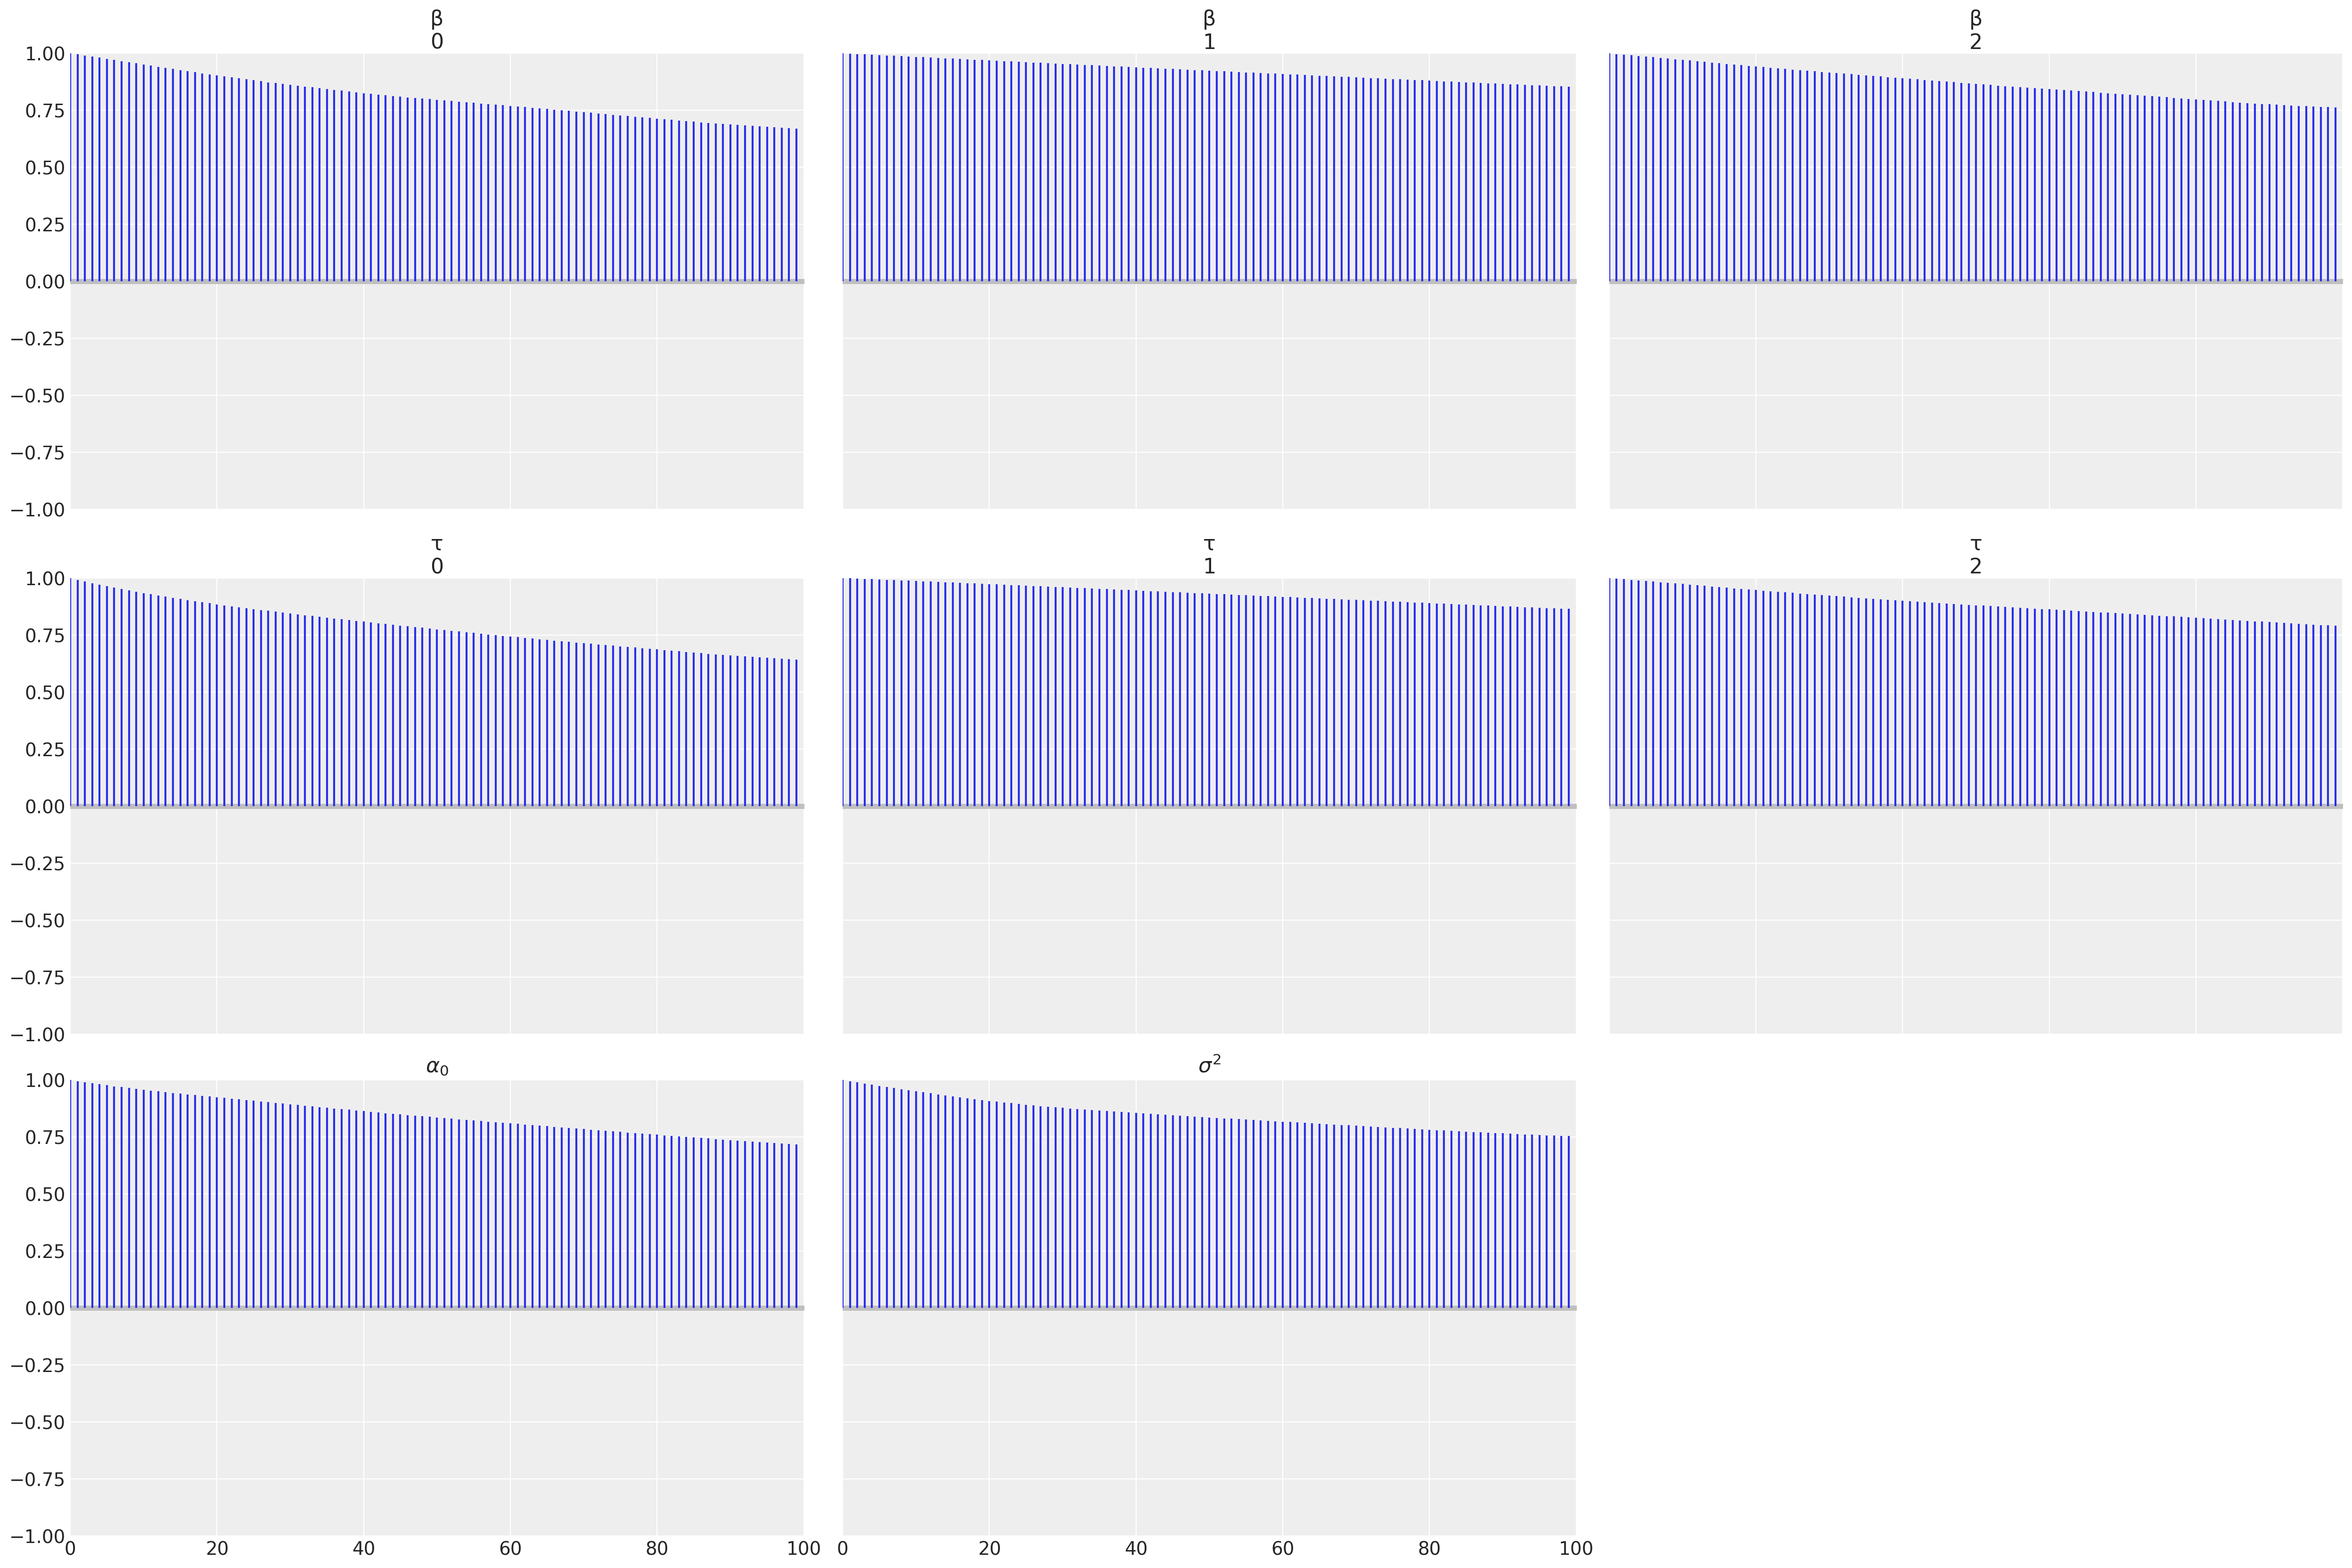

In [31]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

### Out-of-sample predictions

Generating posterior predictive samples...
bpv [T=min]: 0.321
bpv [T=max]: 0.656
bpv [T=median]: 0.943
bpv [T=mean]: 0.566
bpv [T=std]: 0.570


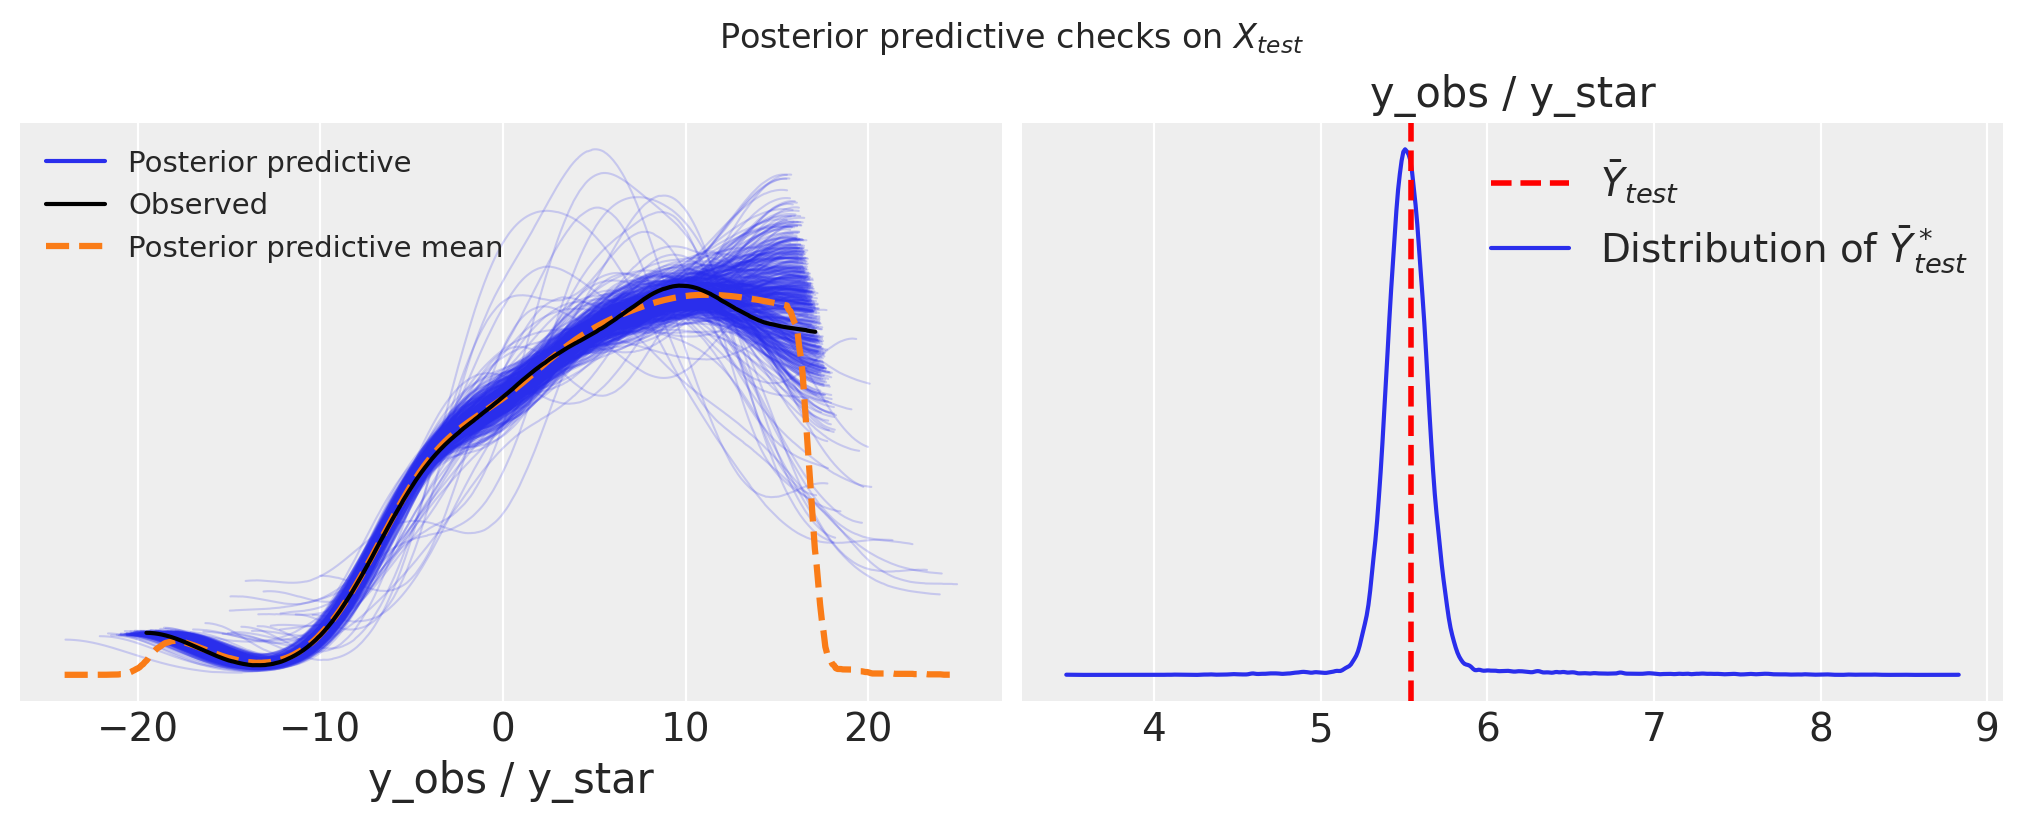

In [32]:
# -- Generate and plot posterior predictive checks from X_test

# Posterior predictive checks
pp_test = bayesian_model.generate_pp(
    idata_emcee,
    X_test,
    theta_space,
    rng=rng,
    verbose=True,
)
idata_pp_test = utils.pp_to_idata(
    [pp_test], idata_emcee, ['y_star'], y_obs=Y_test)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X_{test}$")

plot_utils.plot_ppc(
    idata_pp_test,
    n_samples=500,
    data_pairs={'y_obs': 'y_star'},
    ax=axs[0]
)

az.plot_bpv(
    idata_pp_test,
    kind='t_stat',
    t_stat='mean',
    data_pairs={'y_obs': 'y_star'},
    plot_mean=False,
    ax=axs[1],
    bpv=False
)

axs[1].axvline(
    Y_test.mean(),
    ls="--",
    color="r",
    lw=2,
    label=r"$\bar Y_{test}$"
)

handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*_{test}$")])
_ = axs[1].legend(handles=handles)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

In [33]:
# -- Compute metrics using several point estimates

# Posterior mean estimate
Y_pred_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
df_metrics_emcee = utils.linear_regression_metrics(
    Y_test,
    Y_pred_pp,
    reg_emcee.n_components("posterior_mean"),
    "emcee_posterior_mean"
)

# Point estimates
for pe in reg_emcee.default_point_estimates:
    Y_pred_pe = reg_emcee.predict(X_test, strategy=pe)
    df_metrics_emcee = utils.linear_regression_metrics(
        Y_test,
        Y_pred_pe,
        reg_emcee.n_components(pe),
        "emcee_" + pe,
        df=df_metrics_emcee,
    )

df_metrics_emcee.style.hide_index()

In [34]:
# -- Test variable selection procedure

df_metrics_emcee_var_sel = None

for pe in reg_emcee.default_point_estimates:
    X_red = reg_emcee.transform(X, pe=pe)
    X_test_red = reg_emcee.transform(X_test, pe=pe)

    df_metrics_emcee_var_sel = utils.multiple_linear_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="emcee",
        pe=pe,
        df=df_metrics_emcee_var_sel,
    )

df_metrics_emcee_var_sel.style.hide_index()

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [44]:
# -- Save

with open("emcee-p-fixed.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [45]:
# -- Load

with open("emcee-p-fixed.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

**TODO (v4)**

- Change imports pymc3 -> pymc; theano.tensor -> aesara.tensor
- Try beta = MvNormal
- Try symbolic shape (e.g. tau.shape == p)
- Measure execution times of new pm.sample_posterior_predictive (X should be MutableData (and changed for X_test) for ppc in test set).
- Si beta acaba siendo DensityDist, medir tiempos con y sin parámetros en beta_logp
- Definir adecuadamente los valores iniciales (initval) en p, para que haya al menos uno en cada cadena.
- Añadir random a beta para poder samplear de ella.
- Cambiar start=.. por initvals=... en pm.sample()

In [35]:
from mcmc_sampler import BayesianLinearRegressionPymc
import pymc3 as pm

### Experiments

In [36]:
# -- Sampler parameters

n_chains = N_CORES
USE_NUTS = False

if USE_NUTS:
    n_samples = 500
    n_tune = 500
    step_fn = pm.NUTS
    step_kwargs = {"target_accept": 0.8}
else:
    n_samples = 5000
    n_tune = 1000
    step_fn = pm.Metropolis
    step_kwargs = {}

burn = 0
thin = 1
thin_pp = 5

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [38]:
# -- Run sampler

reg_pymc = BayesianLinearRegressionPymc(
    theta_space,
    n_chains,
    n_samples,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    step_fn=step_fn,
    step_kwargs=step_kwargs,
    n_iter_warmup=n_tune,
    thin=thin,
    thin_pp=thin_pp,
    burn=burn,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    random_state=SEED
)

print(f"-- Running pymc sampler with {N_CORES} cores --")

if FAST_RUN:
    df_metrics_pymc = utils.run_bayesian_model(
        reg_pymc,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="pymc",
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        verbose=True,
        notebook=True,
        random_state=SEED,
    )
    if COMPUTE_MLE:
        df_metrics_pymc = df_metrics_pymc.append(df_metrics_mle)
    if FIT_SK:
        df_metrics_pymc = df_metrics_pymc.append(df_metrics_sk)

    df_metrics_pymc.sort_values(
        df_metrics_pymc.columns[-2],
        inplace=True
    )
    display(df_metrics_pymc.style.hide_index())
else:
    reg_pymc.fit(X, Y)
    print(f"Mean acceptance: {100*reg_pymc.mean_acceptance():.3f}%")

idata_pymc = reg_pymc.get_idata()

-- Running pymc sampler with 4 cores --
[BFLinReg] Computing MLE...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [β]
>Metropolis: [τ]
>Metropolis: [α0_and_LogSq σ2]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.
The number of effective samples is smaller than 10% for some parameters.


[BFLinReg] Discarding the first 0 samples...
Mean acceptance: 20.970%


mean     sd  hdi_3%  hdi_97%     min     max  median    mode
β[0]        -1.281  0.287  -1.823   -0.747  -2.115  -0.304  -1.294  -1.321
β[1]        -4.151  0.372  -4.821   -3.446  -5.440  -3.013  -4.140  -4.087
β[2]        11.038  0.258  10.592   11.531  10.155  12.048  11.030  10.996
τ[0]         0.615  0.044   0.530    0.687   0.389   0.787   0.619   0.639
τ[1]         0.090  0.010   0.075    0.110   0.056   0.123   0.090   0.090
τ[2]         0.795  0.006   0.786    0.804   0.777   0.814   0.796   0.803
$\alpha_0$   4.803  0.064   4.674    4.917   4.568   5.044   4.806   4.818
$\sigma^2$   0.425  0.064   0.318    0.552   0.236   0.773   0.419   0.411


Computing metrics...

Generating posterior predictive samples...


### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

In [39]:
# -- Trace summary

reg_pymc.summary(stats='all')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β[0]        -1.281  0.287  -1.823   -0.747      0.015    0.011     355.0   
β[1]        -4.151  0.372  -4.821   -3.446      0.018    0.013     429.0   
β[2]        11.038  0.258  10.592   11.531      0.015    0.011     277.0   
τ[0]         0.615  0.044   0.530    0.687      0.003    0.002     233.0   
τ[1]         0.090  0.010   0.075    0.110      0.000    0.000     594.0   
τ[2]         0.795  0.006   0.786    0.804      0.000    0.000     894.0   
$\alpha_0$   4.803  0.064   4.674    4.917      0.001    0.001    2110.0   
$\sigma^2$   0.425  0.064   0.318    0.552      0.002    0.001    1272.0   

            ess_tail  r_hat     min     max  median    mode  
β[0]           666.0   1.02  -2.115  -0.304  -1.294  -1.321  
β[1]           641.0   1.01  -5.440  -3.013  -4.140  -4.087  
β[2]           608.0   1.02  10.155  12.048  11.030  10.996  
τ[0]           212.0   1.01   0.389   0.787   0.619   0.639  
τ[1]           746.0   1.01   0.056   0.123   0.090   0.090  
τ[2]          1243.0   1.00   0.777   0.814   0.796   0.803  
$\alpha_0$    2221.0   1.00   4.568   5.044   4.806   4.818  
$\sigma^2$    1804.0   1.00   0.236   0.773   0.419   0.411

Combined density and trace plot:


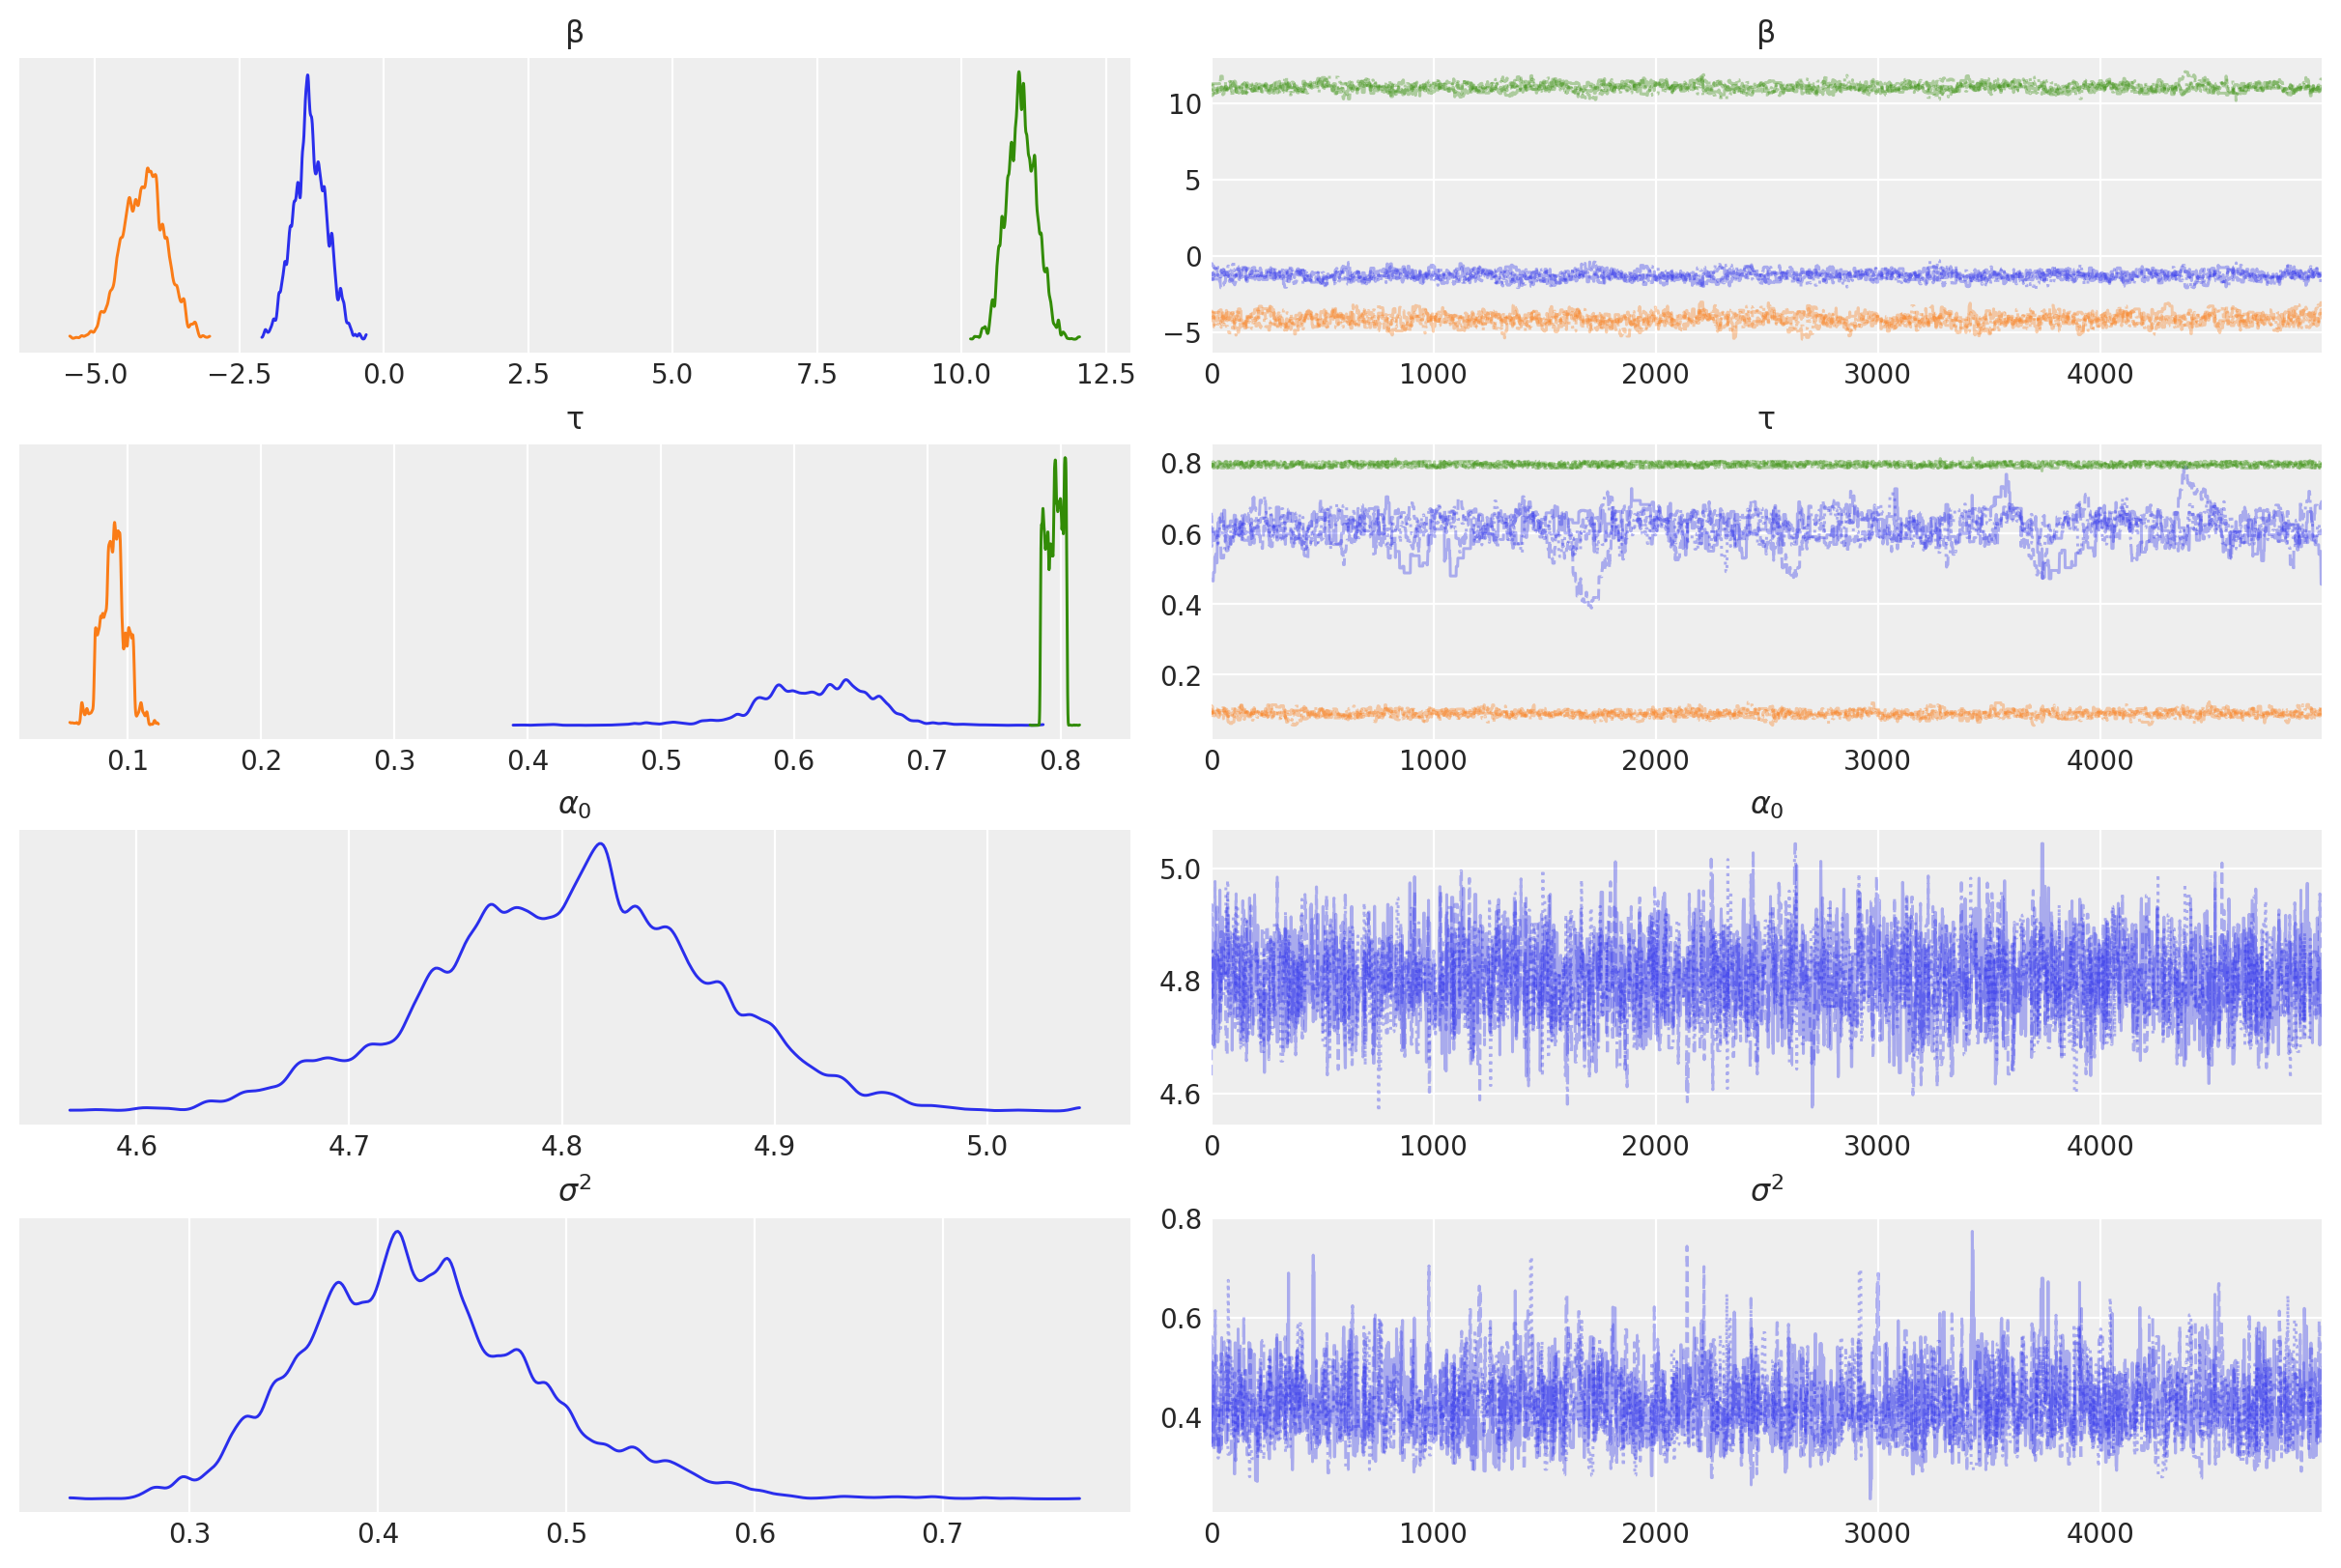

In [40]:
# -- Trace plot

az.plot_trace(
    idata_pymc,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)
print("Combined density and trace plot:")

In [41]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

Marginal posterior distributions:


Generating posterior predictive samples...
bpv [T=min]: 0.450
bpv [T=max]: 0.112
bpv [T=median]: 0.158
bpv [T=mean]: 0.500
bpv [T=std]: 0.581


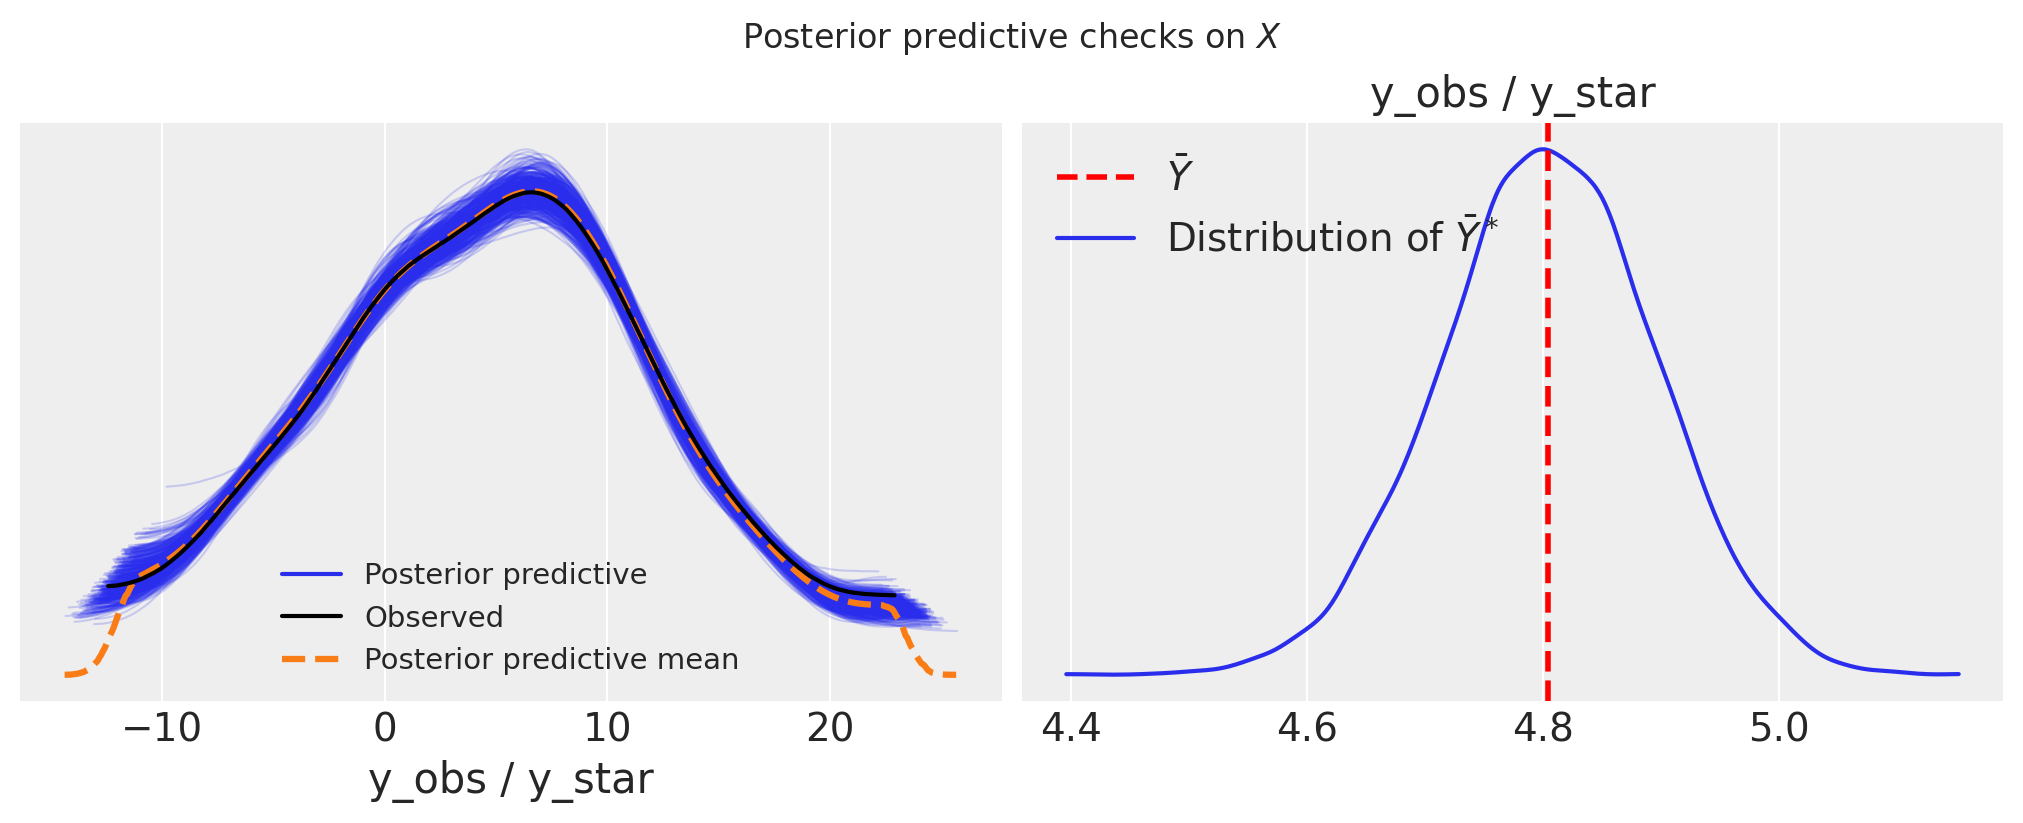

In [42]:
# -- Generate and plot posterior predictive checks from X

pp = bayesian_model.generate_pp(
    idata_pymc, X, theta_space, rng=rng, verbose=True)
utils.pp_to_idata([pp], idata_pymc, ['y_star'], merge=True)

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X$")

plot_utils.plot_ppc(
    idata_pymc,
    n_samples=500,
    ax=axs[0],
    data_pairs={"y_obs": "y_star"}
)

az.plot_bpv(
    idata_pymc,
    kind='t_stat',
    t_stat='mean',
    plot_mean=False,
    ax=axs[1],
    bpv=False,
    data_pairs={"y_obs": "y_star"}
)

axs[1].axvline(
    Y.mean(),
    ls="--",
    color="r",
    lw=2,
    label=r"$\bar Y$"
)

handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*$")])
_ = axs[1].legend(handles=handles)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


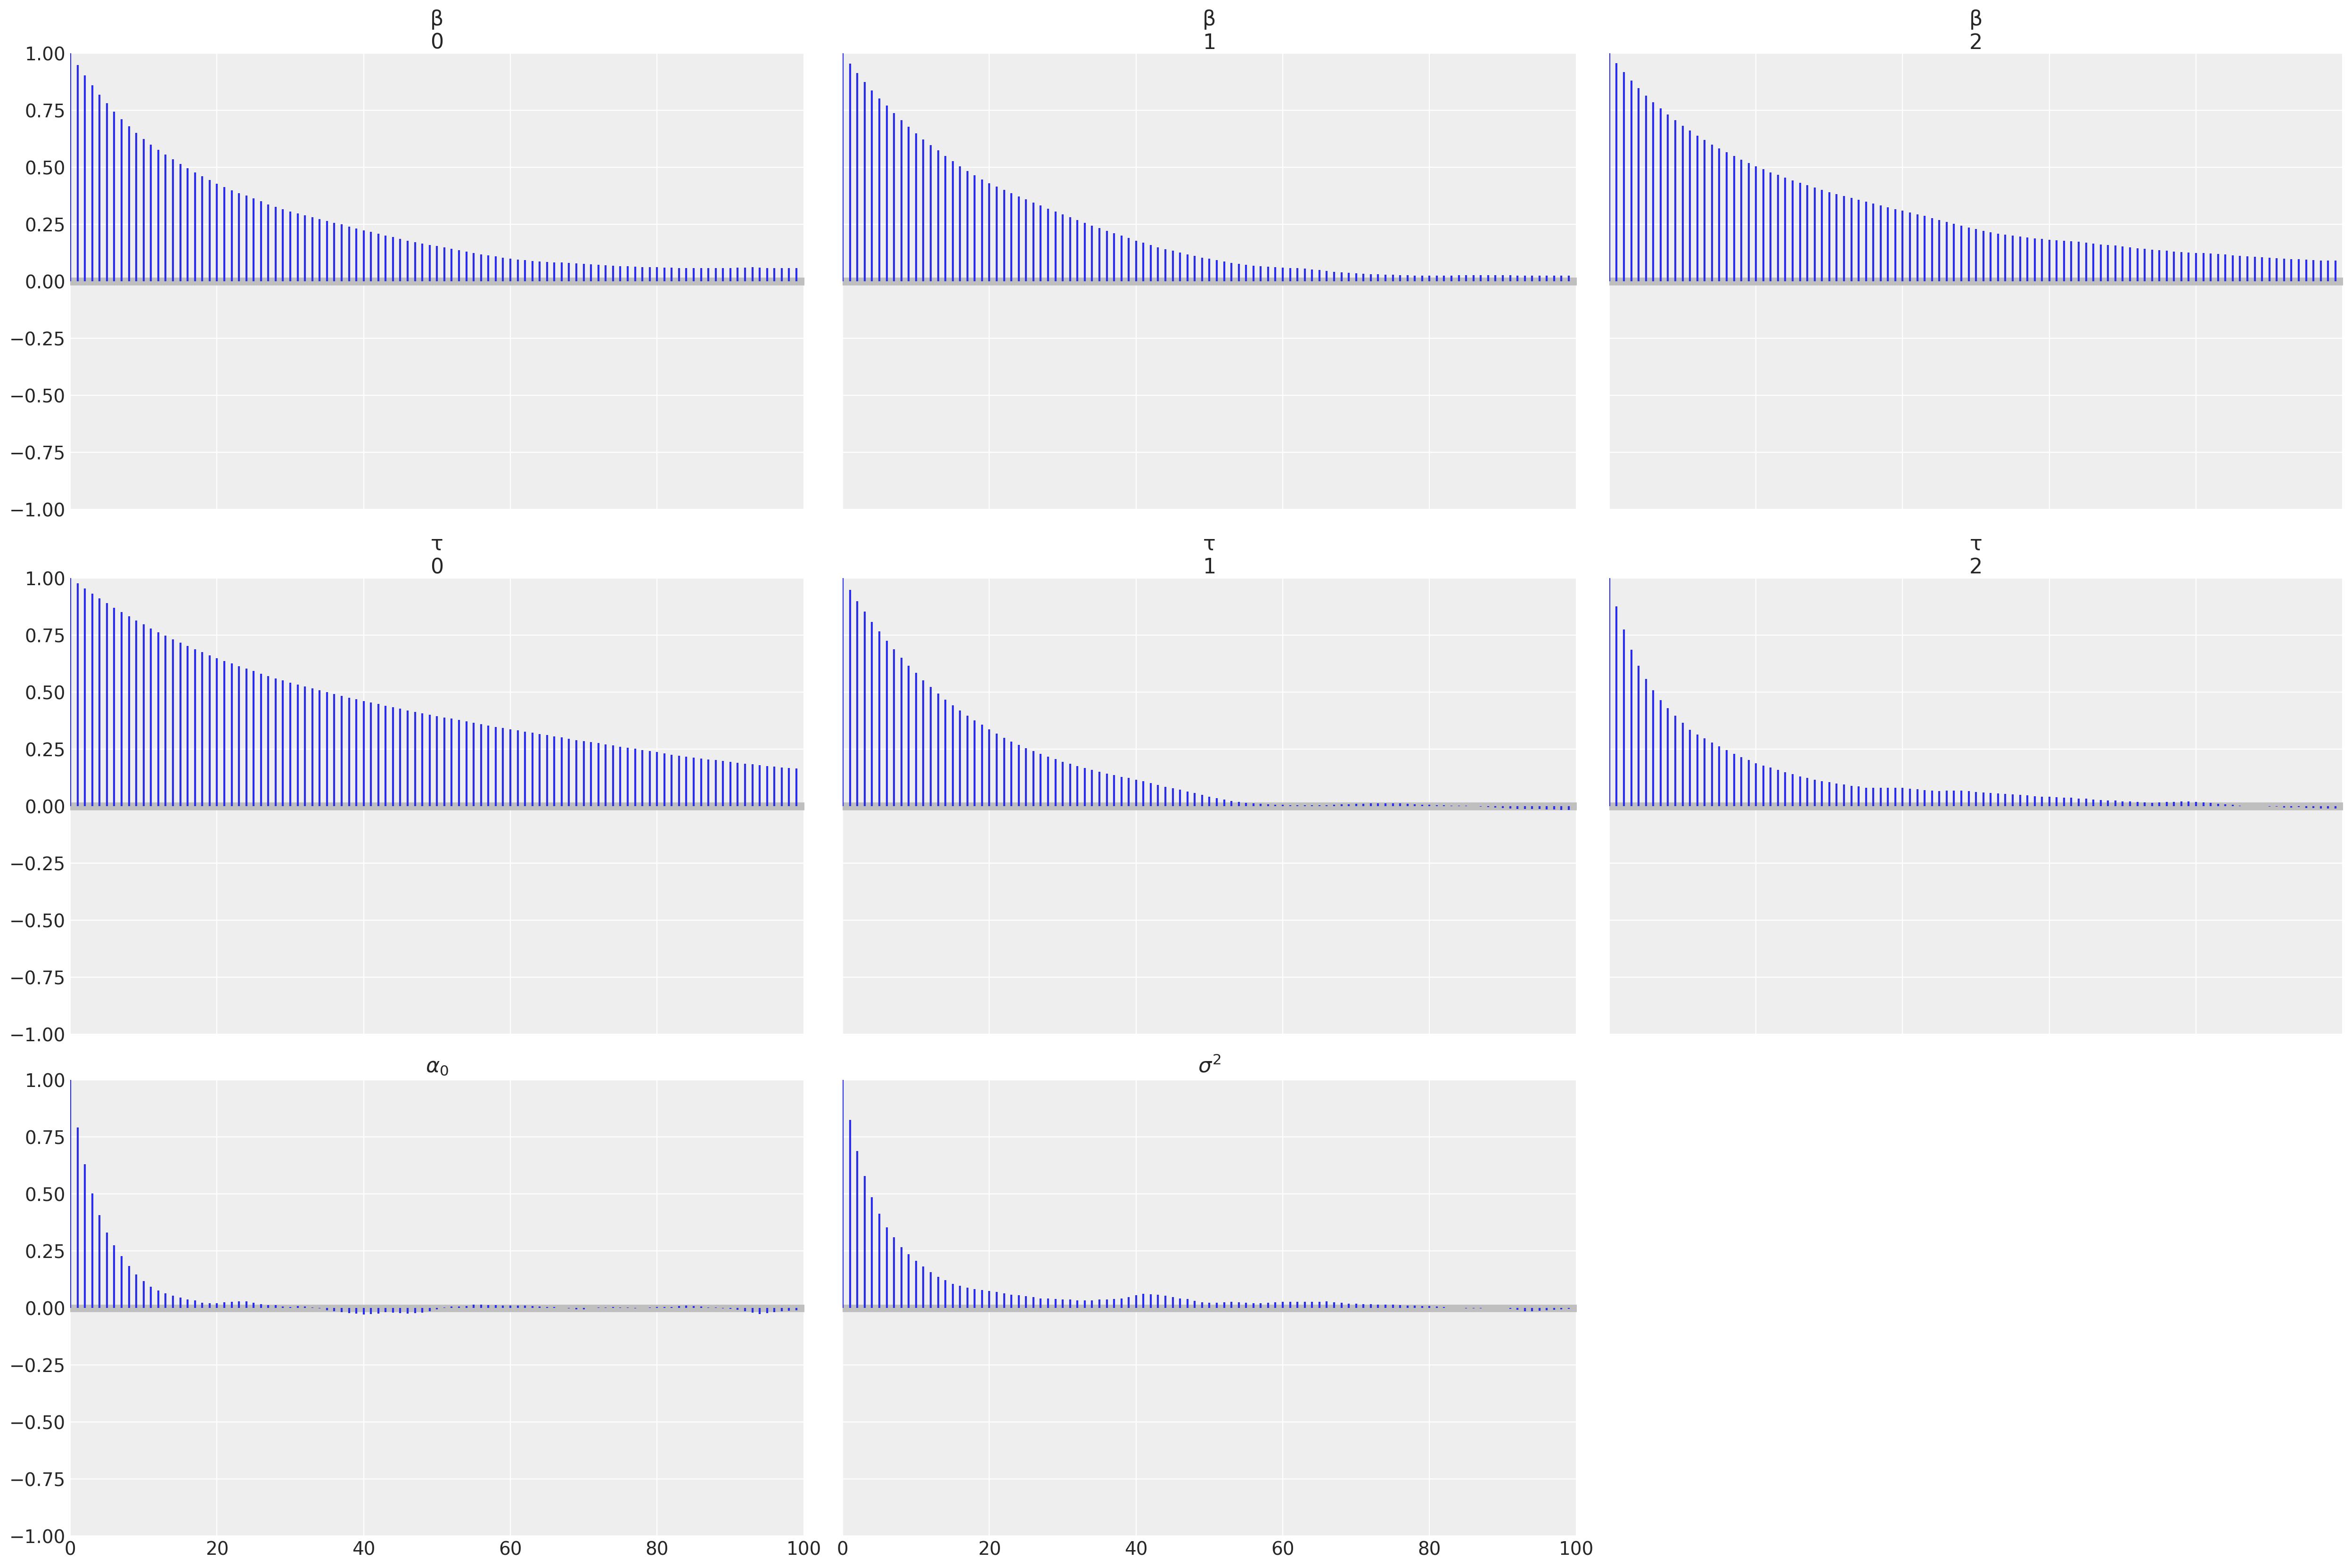

In [43]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

Graphical model:


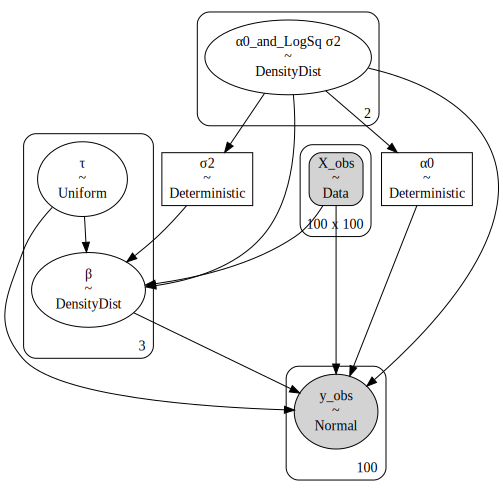

In [44]:
# -- Graphical model

print("Graphical model:")
reg_pymc.to_graphviz()

### Out-of-sample predictions

First we take a look at the distribution of predictions on a previously unseen dataset.

Generating posterior predictive samples...
bpv [T=min]: 0.326
bpv [T=max]: 0.698
bpv [T=median]: 0.950
bpv [T=mean]: 0.565
bpv [T=std]: 0.592


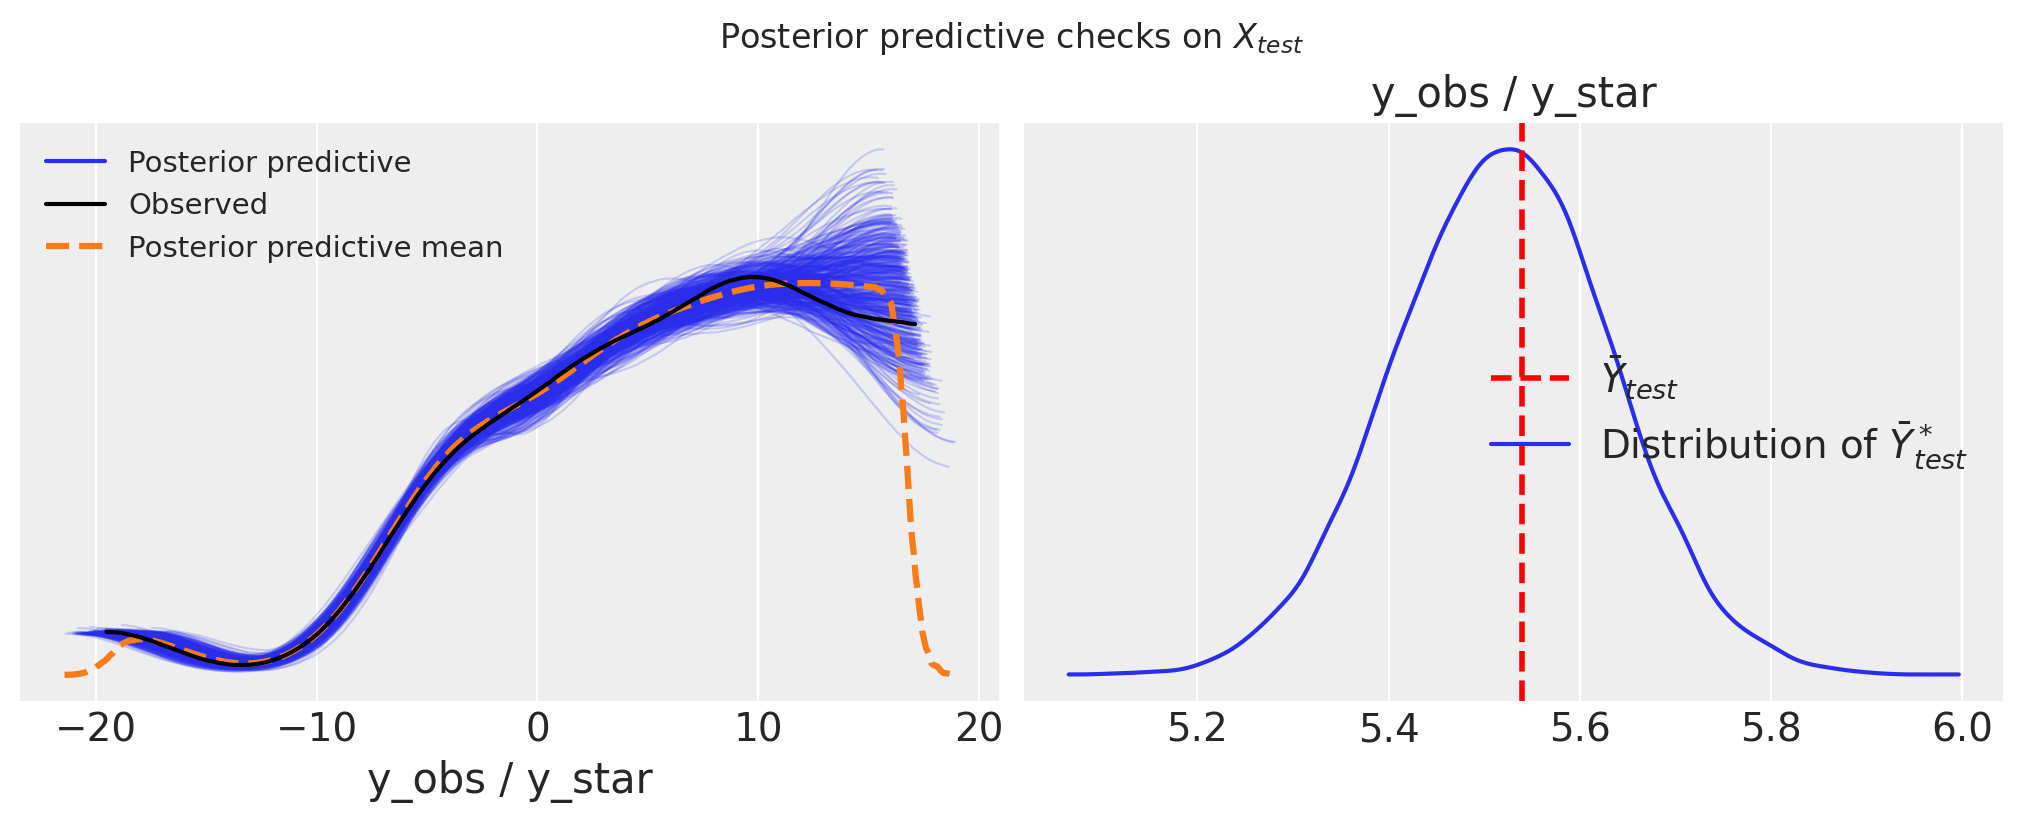

In [45]:
# -- Generate and plot posterior predictive checks from X_test

pp_test = bayesian_model.generate_pp(
    idata_pymc, X_test, theta_space, rng=rng, verbose=True)
idata_pp_test = utils.pp_to_idata(
    [pp_test], idata_pymc, ['y_star'], y_obs=Y_test)

# Posterior predictive checks
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle(r"Posterior predictive checks on $X_{test}$")

plot_utils.plot_ppc(
    idata_pp_test,
    n_samples=500,
    ax=axs[0],
    data_pairs={"y_obs": "y_star"}
)

az.plot_bpv(
    idata_pp_test,
    kind='t_stat',
    t_stat='mean',
    plot_mean=False,
    ax=axs[1],
    bpv=False,
    data_pairs={"y_obs": "y_star"}
)

axs[1].axvline(
    Y_test.mean(),
    ls="--",
    color="r",
    lw=2,
    label=r"$\bar Y_{test}$"
)

handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y_{test}^*$")])
_ = axs[1].legend(handles=handles)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Next we look at the MSE when using several point-estimates for the parameters, as well as the mean of the posterior samples.

In [46]:
# -- Compute metrics using several point estimates

# Posterior mean estimate
Y_pred_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
df_metrics_pymc = utils.linear_regression_metrics(
    Y_test,
    Y_pred_pp,
    reg_pymc.n_components("posterior_mean"),
    "pymc_posterior_mean"
)

# Point estimates
for pe in reg_pymc.default_point_estimates:
    Y_pred_pe = reg_pymc.predict(X_test, strategy=pe)
    df_metrics_pymc = utils.linear_regression_metrics(
        Y_test,
        Y_pred_pe,
        reg_pymc.n_components(pe),
        "pymc_" + pe,
        df=df_metrics_pymc,
    )

df_metrics_pymc.style.hide_index()

In [47]:
# -- Test variable selection procedure

df_metrics_pymc_var_sel = None

for pe in reg_pymc.default_point_estimates:
    X_red = reg_pymc.transform(X, pe=pe)
    X_test_red = reg_pymc.transform(X_test, pe=pe)

    df_metrics_pymc_var_sel = utils.multiple_linear_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="pymc",
        pe=pe,
        df=df_metrics_pymc_var_sel,
    )

df_metrics_pymc_var_sel.style.hide_index()

### Save & Load

In [42]:
# -- Save

_ = idata_pymc.to_netcdf("pymc-p-fixed.nc")

In [43]:
# -- Load

idata_pymc = az.from_netcdf("pymc-p-fixed.nc")

## Notebook metadata

In [48]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon May 23 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.30.1

pymc3     : 3.11.4
matplotlib: 3.5.1
json      : 2.0.9
autopep8  : 1.6.0
numpy     : 1.21.6
arviz     : 0.12.1
pandas    : 1.3.5
skfda     : 0.0
emcee     : 3.1.1

Watermark: 2.2.0

